# The Poisson-Boltzman Distribution

In order to understand lubrication better, we simulate thin layers of lubricant on a metallic surface, solvated in water.
Different structures of lubricant films are created by varying parameters like their concentration and the charge of the surface.
The lubricant is somewhat solvable in water, thus parts of the film will diffuse into the bulk water.
Lubricant molecules are charged, and their distribution is roughly exponential.

As simplification, we  first create a solution of ions (Na+, purple; Cl-, green) in water (not shown).
![pic](https://i.ibb.co/Yh8DxVM/showpicture.png)

Close to the positively charged metallic surface, the electric potential (red) will be highest, falling off exponentially when further away.
This potential attracts negatively charged Chlorine ions, and pushes positively charged Natrium ions away, resulting in a higher (lower) concentration of Clorine (Natrium) near the surface.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

# Sampling and plotting
from continuous2discrete import generate_structure 
from continuous2discrete import plot_dist
from continuous2discrete import get_histogram
from IPython.display import Image

In [3]:
# Physical distribution generation
from continuous2discrete.poisson_bolzmann_distribution import debye 
from continuous2discrete.poisson_bolzmann_distribution import gamma
from continuous2discrete.poisson_bolzmann_distribution import charge_density
from continuous2discrete.poisson_bolzmann_distribution import potential

np.random.seed(74)

To calculate this, we first need to find out how ions are distributed in solution.
A good description of the concentration of our ion species, $c_{Na^+}$, is given by the solution to the Poisson-Bolzmann equation:

$
\begin{align}
\rho_{Na^+}(z) &= \rho_{Na^+}(\infty) e^{-e \Psi(z)/k_B T}\\
\Psi(z) &= \frac{2k_B T}{e} \log\Big(\frac{1 + \gamma e^{-\kappa z}}{1- \gamma e^{-\kappa z}}\Big) 
        \approx \frac{4k_B T}{e} \gamma e^{-\kappa z} \\
\gamma &= \tanh(\frac{e\Psi(0)}{4k_B T})\\
\kappa &= 1/\lambda_D\\
\lambda_D &= \Big(\frac{\epsilon \epsilon_0 k_B T}{\sum_{i} \rho_i(\infty) e^2 z_i^2} \Big)^\frac{1}{2} [m^{-1}]
\end{align}
$

With:
* $z$: Distance from the double layer
* $\Psi(0)$: Potential at the surface
* $\Psi(z)$: Potential in the solution
* $k_B$: Bolzmann Constant
* $T$: Temperature [Kelvin]
* $e$: Elemental Charge (or Euler's constant when exponentiated)
* $\gamma$: Term from Gouy-Chapmann theory
    * $\gamma \rightarrow 1$ for high potentials
    * $\Psi(z) \approx \Psi_0 e^{-\kappa z}$ for low potentials $\Psi(0) \approx 0$
* $\lambda_D$: Debye Length (34.0 nm for NaCl, 10^-4 M, 25°C)
* $\rho_{Na^+}$: Concentration of Natrium ions
* $\rho_{Na^+}(\infty)$: Bulk Natrium concentration (at infinity, where the solution is homogeneous)
* $\epsilon$: Permittivity of the solution
* $\epsilon_0$: Electric constant aka Vacuum permittivity
* $z_i$: Charge of species i 


These equations are implemented in `poisson_bolzmann_distribution.py`

Debye Length of 10^-4 M saltwater: 30.52 nm (Target: 30.4 nm)


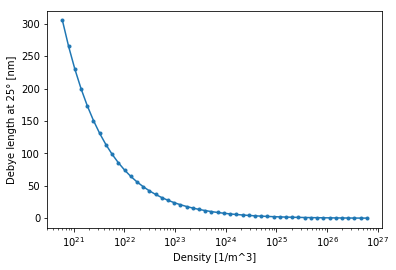

In [14]:
default_density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': default_density, 'Cl': default_density} 
charge = {'Na': 1, 'Cl': -1}
deb = debye(rho_bulk=rho, charge=charge) * 10**9
print('Debye Length of 10^-4 M saltwater: {} nm (Target: 30.4 nm)'.format(round(deb, 2)))

density = np.logspace(-6, 0, 50) * sc.Avogadro * 1000
debyes = [debye(rho_bulk={'Na': d, 'Cl': d}, charge=charge) * 10**9 for d in density]

plt.xlabel('Density [1/m^3]')
plt.ylabel('Debye length at 25° [nm]')
plt.semilogx(density, debyes, marker='.')
plt.show()

The debye length depends on the concentration of ions in solution, at low concentrations it becomes large. We can reproduce literature debye lengths with our function, so everything looks good.

## Gamma Function

Next we calculate the gamma function $\gamma = \tanh(\frac{e\Psi(0)}{4k_B T})$

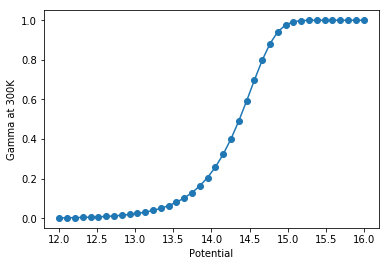

In [15]:
x = np.linspace(12, 16, 40)
gammas = [gamma(10 ** i, 300) for i in x]
plt.xlabel('Potential')
plt.ylabel('Gamma at 300K')
plt.plot(x, gammas, marker='o')
plt.show()

Which looks as expected, but we have no values to compare it against.

## Potential

We plug these two functions into the expression for the potential

$\Psi(z) = \frac{2k_B T}{e} \log\Big(\frac{1 + \gamma e^{-\kappa z}}{1- \gamma e^{-\kappa z}}\Big) 
        \approx \frac{4k_B T}{e} \gamma e^{-\kappa z}$

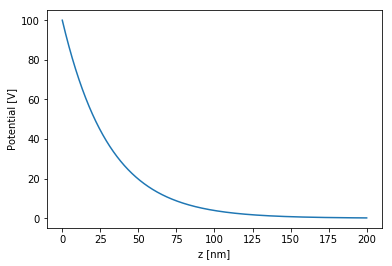

In [16]:
z = np.linspace(0, 2*10**-7, 10000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 100
psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]
plt.xlabel('z [nm]')
plt.ylabel('Potential [V]')
plt.plot(z*10**9, psi, marker='')
plt.show()

The potential is smooth and looks roughly exponential. Everything good so far.

## Charge density

Now we obtain the charge density $\rho$ from the potential $\Psi$ via

$\rho_{Na^+}(z) = \rho_{Na^+}(\infty) e^{-e \Psi(z)/k_B T}$

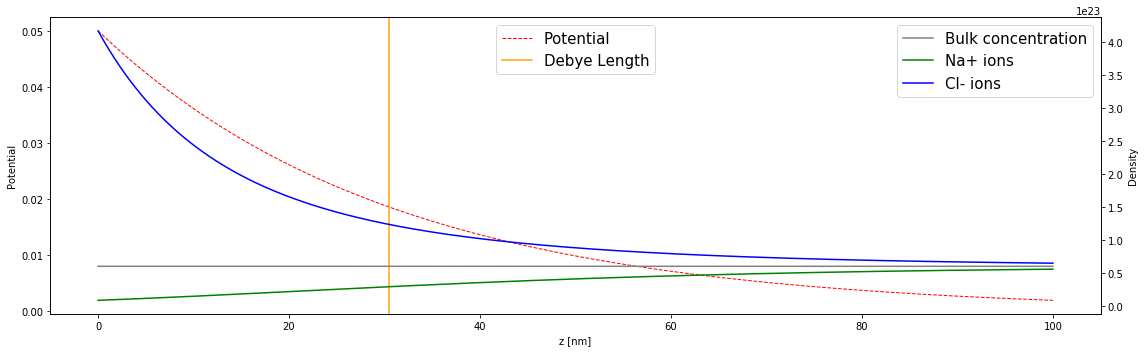

In [17]:
z = np.linspace(0, 100*10**-9, 2000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 0.05  # Breaks if > 1

psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Cl') for loc in z])

deb = debye(rho_bulk=rho, charge=charge) * 10**9

fig, ax1 = plt.subplots(figsize=[16,5])
ax1.set_xlabel('z [nm]')
ax1.plot(z*10**9, psi, marker='', color='red', label='Potential', linewidth=1, linestyle='--')
ax1.set_ylabel('Potential')
ax1.axvline(x=deb, label='Debye Length', color='orange')

ax2 = ax1.twinx()
ax2.plot(z*10**9, [density]*len(z), label='Bulk concentration', color='grey')
ax2.plot(z*10**9, rho_na, marker='', color='green', label='Na+ ions')
ax2.plot(z*10**9, rho_cl, marker='', color='blue', label='Cl- ions')
ax2.set_ylabel('Density')

#fig.legend(loc='center')
ax2.legend(loc='best', fontsize=15)
ax1.legend(loc='upper center', fontsize=15)
fig.tight_layout()
plt.show()

The charge density behaves as expected, it interpolates between low (high) concentration and the bulk concentration within the first few debye lengths.

## Sampling
Now let's see if we can just plug our new distribution in our existing framework.

First, we need to convert the physical distribution to the format we were using so far:

In [7]:
def wrap_distribution(x, species):
    """Wrapper for na+ ions."""
    density = sc.Avogadro * 1000 * 10**-4
    rho = {'Na': density, 'Cl':density} 
    charge = {'Na': 1, 'Cl': -1}
    pot_0 = 0.05  # Breaks if > 1
    
    def call_distri(loc):
        distri = charge_density(location=loc, rho_bulk=rho, 
                                charge=charge, surface_potential=pot_0, species=species)
        return float(distri)
    
    if not np.isscalar(x):
        y = []
        for i in range(0, len(x)):
            val = call_distri(x[i])
            
            # Normalize to be 1 at x=0
            val /= call_distri(0)
            # Scale distribution to have values in [0, 0.1] for ease of sampling
            val /= 10
            y += [val]
        return np.array(y)

    # If we have only a point estimate
    val = call_distri(x)
    # Normalize to be 1 at x=0
    val /= call_distri(0)
    # Scale distribution to have values in [0, 0.1] for ease of sampling
    val /= 10    
    return val
    
def cl_distribution(x):
    return wrap_distribution(x, species='Cl')

def na_distribution(x):
    return wrap_distribution(x, species='Na')

Now we can sample the distribution of our $Na^+$ ions in z-direction.

In [8]:
x = 50 * 10**-9
z = 100 * 10**-9
box = np.array([x, x, z])
sample_size = 10000

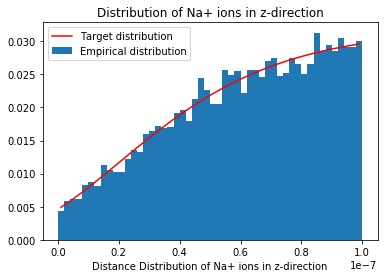

In [9]:
struc = generate_structure(distribution=na_distribution, box=box, atom_count=sample_size)
histx, histy, histz = get_histogram(struc, box=box, n_bins=51)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=na_distribution)

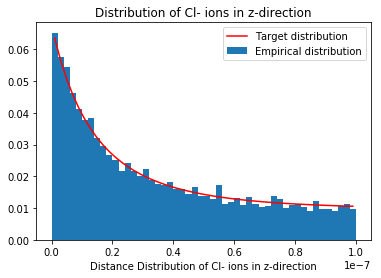

In [10]:
struc = generate_structure(distribution=cl_distribution, box=box, atom_count=sample_size)
histx, histy, histz = get_histogram(struc, box=box, n_bins=51)
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=cl_distribution)

## Write to file
To visualize our structure, we export it to the .xyz file format, which is basically

```
ATOM_NUMBER
Optional comment
atom_type x y z
atom_type x y z
```

Avogadro expects x, y, z to be in units of $10^{-9}~m$, so we convert our salt "solution" to this unit.

Also, we use fewer atoms, just 100 for the 100x50x50 box - this will increase fluctuations with respect to the correct distribution though.

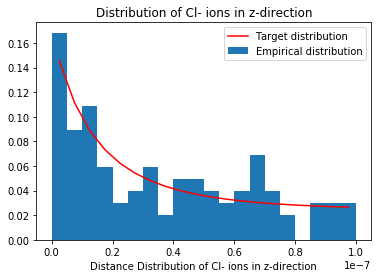

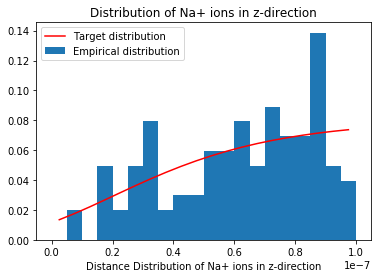

In [11]:
from generate_structure import concat_names_structs
from generate_structure import export_named_struc

cl_struc = generate_structure(distribution=cl_distribution, box=box, atom_count=100)
na_struc = generate_structure(distribution=na_distribution, box=box, atom_count=100)

concat_list = concat_names_structs(struc_list=[cl_struc, na_struc], name_list=['Cl', 'Na'])
rescaled_list = []
for line in concat_list:
    name, x, y, z = line
    x = float(x) * 10**9
    y = float(y) * 10**9
    z = float(z) * 10**9    
    rescaled_list += [[name, x, y, z]]

rescaled_list = np.array(rescaled_list)
export_named_struc(rescaled_list)

histx, histy, histz = get_histogram(cl_struc, box=box, n_bins=21)
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=cl_distribution)

histx, histy, histz = get_histogram(na_struc, box=box, n_bins=21)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=na_distribution)

Now we can import the xyz file into avogadro, the visualization should look like this:

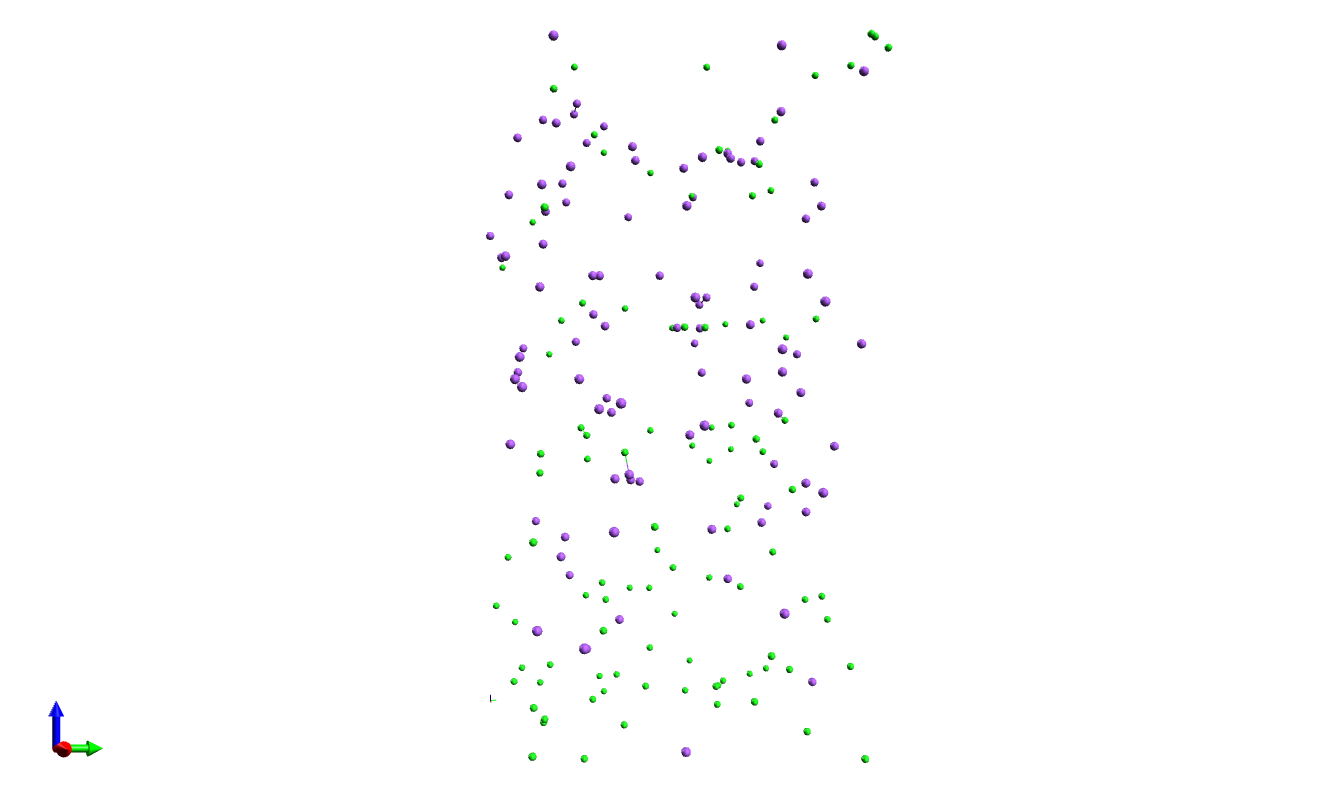

In [12]:
Image(filename='distributed_atom_structure.png') 

## General Poisson-Nernst-Planck System

In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

A binary Poisson-Nernst-Planck system corresponds to the transport problem in semiconductor physics.
In this context, Debye length, charge carrier densities and potential are related as folloes

Woher kommt die Debye-Länge

$$ \lambda = \sqrt{ \frac{\varepsilon \varepsilon_0 k_B T}{q^2 n_i} }$$

als natürliche Längeneinheit des Transportptoblems?

Hier ist $n_i$ eine Referenzladungsträgerdichte, in der Regel die intrinsische Ladungsträgerdichte. 
In dem Beispiel mit $N^+NN^+$-dotiertem Halbleiter erzeugen wir durch unterschiedliches Doping an den Rändern die erhöhte Donatorendichte $N_D^+ = 10^{20} \mathrm{cm}^{-3}$ und im mitteleren Bereich "Standarddonatorendichte" $N_D = 10^{18} \mathrm{cm}^{-3}$. Nun können wir als Referenz $n_i = N_D$ wählen und die Donatorendichten als $N_D = 1 \cdot n_i$ und $N_D^+ = 100 \cdot n_i$ ausdrücken. Diese normierte Konzentration nennen wir einfach $\tilde{N}_D$: $N_D = \tilde{N}_D \cdot n_i$.

Ein ionisierter Donator trägt die Ladung $q$, ein Ladungsträger (in unserem Fall ein Elektron) trägt die Elementarladung $-q$. Die Raumladungsdichte $\rho$ in der Poissongleichung

$$ \nabla^2 \varphi = - \frac{\rho}{\varepsilon \varepsilon_0}$$

lässt sich also ganz einfach als $\rho = - (n - N_D) \cdot q = - (\tilde{n} - \tilde{N}_D) ~ n_i ~ q$ ausdrücken. 

Konventionell wird das Potential auf $u = \frac{\phi ~ q}{k_B ~ T}$ normiert. Die Poissongleichung nimmt damit die Form

$$\frac{k_B ~ T}{q} \cdot \nabla^2 u = \frac{(\tilde{n} - \tilde{N}_D) ~ n_i ~ q }{\varepsilon \varepsilon_0}$$

oder auch 

$$ \frac{\varepsilon ~ \varepsilon_0 ~ k_B ~ T}{q^2 n_i} \cdot \nabla^2 u = \lambda^2 \cdot \nabla^2 u = \tilde{n} - \tilde{N}_D$$



Poisson- und Drift-Diffusionsgleichung

$$ 
\lambda^2 \frac{\partial^2 u}{\partial x^2} = n - N_D
$$

$$ 
\frac{\partial n}{\partial t} = - D_n \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) + R
$$

Skaliert mit [l], [t]:

$$ 
\frac{\lambda^2}{[l]^2} \frac{\partial^2 u}{\partial \tilde{x}^2} = n - N
$$

und

$$ 
\frac{1}{[t]} \frac{\partial n}{\partial \tilde{t}} = - \frac{D_n}{[l]^2} \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) + R 
$$

oder

$$ 
\frac{\partial n}{\partial \tilde{t}} = - \tilde{D}_n \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) +  \tilde{R} 
$$

mit 

$$ 
\tilde{D}_n = D_n \frac{[t]}{[l]^2} \Leftrightarrow [t] = [l]^2 \ \frac{ \tilde{D}_n } { D_n } 
$$
    
und

$$ \tilde{R} = \frac{n - N_D}{\tilde{\tau}}$$ 

mit $\tilde{\tau} = \tau / [t]$. 

$\tilde{\lambda} = 1$ und $\tilde{D_n} = 1$ werden mit
$[l] = \lambda$ und $[t] = \frac{\lambda^2}{D_n}$ erreicht:

## Discretization

Naive Diskretisierung (skaliert):

$$ \frac{1}{\Delta x^2} ( u_{i+1}-2u_i+u_{i-1} ) = n_i - N_i $$

$$ \frac{1}{\Delta t} ( n_{i,j+1} - n_{i,j} ) = - \frac{1}{\Delta x^2} \cdot \left[ \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) \right] + \frac{ n_i - N_i}{ \tilde{\tau} } $$

Stationär:

$$
 u_{i+1}-2u_i+u_{i-1} - \Delta x^2 \cdot n_i + \Delta x^2 \cdot N_i = 0
$$

und

$$
  \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) - \Delta x^2 \cdot \frac{ n_i - N_i}{ \tilde{\tau} } = 0
$$

## Newton-Iteration für gekoppeltes nicht-lineares Gleichungssystem

Idee: Löse nicht-lineares Finite-Differenzen-Gleichungssystem über Newton-Verfahren  

$$ \vec{F}(\vec{x}_{k+1}) = F(\vec{x}_k + \Delta \vec{x}_k) \approx F(\vec{x}_k) + \mathbf{J_F}(\vec{x}_k) \cdot \Delta \vec{x}_k + \mathcal{O}(\Delta x^2)$$
   
mit Unbekannter $\vec{x_k} = \{u_1^k, \dots, u_N^k, n_1^k, \dots, n_N^k\}$  und damit

$$ \Rightarrow \Delta \vec{x}_k = - \mathbf{J}_F^{-1} ~ F(\vec{x}_k)$$

wobei die Jacobi-Matrix $2N \times 2N$ Einträge

$$ \mathbf{J}_{ij}(\vec{x}_k) = \frac{\partial F_i}{\partial x_j} (\vec{x}_k) $$

besitzt, die bei jedem Iterationsschritt für $\vec{x}_k$ ausgewertet werden.
Der tatsächliche Aufwand liegt in der Invertierung der Jacobi-Matrix, um in jeder Iteration $k$ den Korrekturschritt $\Delta \vec{x}_k$ zu finden.m

$F(x)$ wird wie unten (G_steady) definiert als:

$$
 u_{i+1}-2u_i+u_{i-1} - \Delta x^2 \cdot n_i + \Delta x^2 \cdot N_i = 0
$$

und

$$
  \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) - \Delta x^2 \cdot \frac{ n_i - N_i}{ \tilde{\tau} } = 0
$$

In [327]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [328]:
import logging

In [329]:
import matplotlib.pyplot as plt

In [330]:
logging.shutdown()

In [331]:
from continuous2discrete.poisson_nernst_planck_distribution import PoissonNernstPlanckSystem

In [332]:
standard_loglevel   = logging.INFO
standard_logformat  = ''.join(("%(asctime)s:%(name)s:%(levelname)s",
  "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"))

In [333]:
standard_loglevel   = logging.DEBUG
standard_logformat  = ''.join(("%(asctime)s",
  "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"))

In [334]:
logging.basicConfig(level=standard_loglevel,
                    format=standard_logformat,
                    datefmt='%m-%d %H:%M')

In [335]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [336]:
logger.handlers

[<StreamHandler stderr (DEBUG)>]

In [337]:
for h in logger.handlers: logger.removeHandler(h)

In [338]:
ch = logging.StreamHandler()

In [339]:
formatter = logging.Formatter(standard_logformat)

In [340]:
ch.setFormatter(formatter)

In [341]:
ch.setLevel(logging.DEBUG)

In [342]:
logger.addHandler(ch)

In [343]:
logging.info("Root logger")

2019-10-28 16:18:54,625[ <ipython-input-343-76c44f934275>:1 - <module>() ]: Root logger


In [344]:
logger.info("Root Logger")

2019-10-28 16:18:54,731[ <ipython-input-344-ba755ac4c916>:1 - <module>() ]: Root Logger


In [380]:
pnp = PoissonNernstPlanckSystem()

2019-10-28 16:34:22,421[ poisson_nernst_planck_distribution.py:491 - __init__() ]: ion species 00 concentration c                0.1
2019-10-28 16:34:22,423[ poisson_nernst_planck_distribution.py:493 - __init__() ]: ion species 00 number charge z                  1
2019-10-28 16:34:22,424[ poisson_nernst_planck_distribution.py:491 - __init__() ]: ion species 01 concentration c                0.1
2019-10-28 16:34:22,425[ poisson_nernst_planck_distribution.py:493 - __init__() ]: ion species 01 number charge z                 -1
2019-10-28 16:34:22,426[ poisson_nernst_planck_distribution.py:496 - __init__() ]: temperature T                               298.1
2019-10-28 16:34:22,427[ poisson_nernst_planck_distribution.py:498 - __init__() ]: domain size L                               1e-07
2019-10-28 16:34:22,427[ poisson_nernst_planck_distribution.py:500 - __init__() ]: potential difference delta_u                 0.05
2019-10-28 16:34:22,428[ poisson_nernst_planck_distribution.py:502 - 

In [381]:
pnp.output = True

In [382]:
pnp.N = 100

In [383]:
pnp.maxit = 10

In [384]:
pnp.useStandardInterfaceBC()

2019-10-28 16:34:24,119[ poisson_nernst_planck_distribution.py:310 - useStandardInterfaceBC() ]: Left hand side Dirichlet boundary condition:  u0 =    1.946
2019-10-28 16:34:24,121[ poisson_nernst_planck_distribution.py:311 - useStandardInterfaceBC() ]: Right hand side Dirichlet boundary condition: u1 =        0


In [385]:
pnp.init()

2019-10-28 16:34:24,588[ poisson_nernst_planck_distribution.py:241 - init() ]: discretization segments N                     100
2019-10-28 16:34:24,589[ poisson_nernst_planck_distribution.py:243 - init() ]: grid points N                                 101
2019-10-28 16:34:24,590[ poisson_nernst_planck_distribution.py:257 - init() ]: dx:                            0.03277
2019-10-28 16:34:24,591[ poisson_nernst_planck_distribution.py:258 - init() ]: dx2overtau:                         10


2019-10-28 16:34:25,379[ poisson_nernst_planck_distribution.py:114 - newton() ]: Newton solver, grid points N = 100
2019-10-28 16:34:25,380[ poisson_nernst_planck_distribution.py:115 - newton() ]: Newton solver, tolerance e =    1e-10
2019-10-28 16:34:25,381[ poisson_nernst_planck_distribution.py:116 - newton() ]: Newton solver, maximum number of iterations M = 10
2019-10-28 16:34:25,411[ poisson_nernst_planck_distribution.py:143 - newton() ]: Convergence criterion: norm(dx) < 1.00e-10
2019-10-28 16:34:25,411[ poisson_nernst_planck_distribution.py:151 - newton() ]: *** Newton solver iteration 0 ***
2019-10-28 16:34:25,412[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:25,412[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,412[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 

2019-10-28 16:34:25,441[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:25,441[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:25,442[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:25,442[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:25,442[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:25,443[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,443[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:25,444[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:25,468[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:25,469[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,470[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:25,470[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:25,471[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:25,471[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,472[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,472[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:25,510[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:25,511[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:25,511[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:25,512[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:25,512[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:25,513[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,513[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:25,514[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:25,556[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:25,557[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,558[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:25,560[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:25,567[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:25,568[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,568[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,569[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:25,609[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:25,610[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:25,610[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:25,611[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:25,611[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:25,612[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,612[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:25,612[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:25,638[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:25,639[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,639[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:25,643[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:25,644[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:25,644[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,645[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,645[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:25,673[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:25,674[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:25,674[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:25,675[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:25,675[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:25,676[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,676[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:25,677[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:25,705[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:25,705[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,707[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:25,707[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:25,707[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:25,708[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,708[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,708[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:25,742[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:25,743[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:25,743[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:25,744[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:25,745[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:25,746[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,746[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:25,747[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:25,773[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:25,773[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,774[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:25,774[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:25,774[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:25,775[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,775[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,775[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:25,801[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:25,801[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:25,801[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:25,802[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:25,802[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:25,803[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,803[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:25,803[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:25,835[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:25,836[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,836[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:25,837[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:25,837[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:25,838[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,838[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,839[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:25,864[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:25,865[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:25,865[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:25,866[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:25,866[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:25,867[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,868[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:25,868[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:25,895[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:25,895[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,896[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:25,896[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:25,896[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:25,897[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,897[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,898[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:25,924[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,925[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:25,925[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:25,926[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:25,926[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:25,927[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:25,927[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,943[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 0

2019-10-28 16:34:25,970[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:25,970[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:25,971[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:25,972[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:25,972[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:25,972[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:25,973[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,973[ poisson_nernst_planck_distribution.py:381 - G() ]: ion sp

2019-10-28 16:34:25,998[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:25,998[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:25,999[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:25,999[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,000[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,000[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,001[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,001[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 0

2019-10-28 16:34:26,028[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,028[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,029[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,029[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,029[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,030[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,030[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,030[ poisson_nernst_planck_distribution.py:381 - G() ]: ion sp

2019-10-28 16:34:26,076[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,076[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,077[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,077[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,077[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,078[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,079[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,079[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 0

2019-10-28 16:34:26,105[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,106[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,106[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,107[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,108[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,108[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,109[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,109[ poisson_nernst_planck_distribution.py:381 - G() ]: ion sp

2019-10-28 16:34:26,135[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,135[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,136[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,136[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,137[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,137[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,138[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,139[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 0

2019-10-28 16:34:26,195[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,195[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,196[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,196[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,197[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,197[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,198[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,198[ poisson_nernst_planck_distribution.py:381 - G() ]: ion sp

2019-10-28 16:34:26,227[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,227[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,228[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,228[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,229[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,229[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,230[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,230[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 0

2019-10-28 16:34:26,255[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,255[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,256[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,257[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,257[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,257[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,258[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,258[ poisson_nernst_planck_distribution.py:381 - G() ]: ion sp

2019-10-28 16:34:26,298[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,298[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,299[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,299[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,299[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,300[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,300[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,301[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann B

2019-10-28 16:34:26,330[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,330[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,331[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,331[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,332[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,332[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,332[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,332[ poisson_nernst_planck_distribution.py:381 - G() ]

2019-10-28 16:34:26,359[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,360[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,360[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,361[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,361[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,362[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,363[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,364[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann B

2019-10-28 16:34:26,403[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,403[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,403[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,404[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,404[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,405[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,405[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,406[ poisson_nernst_planck_distribution.py:381 - G() ]

2019-10-28 16:34:26,430[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,431[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,431[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,431[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,431[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,432[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,432[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,433[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann B

2019-10-28 16:34:26,464[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,464[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,465[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,465[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,466[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,466[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,467[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,467[ poisson_nernst_planck_distribution.py:381 - G() ]

2019-10-28 16:34:26,504[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,505[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,505[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,505[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,506[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,506[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,506[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,507[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC re

2019-10-28 16:34:26,533[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,534[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,535[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,536[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,537[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,537[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,538[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,538[ poisson_nernst_planck_distribution.py:373 - G() ]: pote

2019-10-28 16:34:26,564[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,564[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,564[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,565[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,565[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,565[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,566[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,566[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC re

2019-10-28 16:34:26,599[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,601[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,601[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,602[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,602[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,602[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,603[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,603[ poisson_nernst_planck_distribution.py:373 - G() ]: pote

2019-10-28 16:34:26,643[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,644[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,644[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,645[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,645[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,646[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,646[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,647[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC re

2019-10-28 16:34:26,674[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,675[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,675[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,676[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,677[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,677[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,678[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,678[ poisson_nernst_planck_distribution.py:373 - G() ]: pote

2019-10-28 16:34:26,706[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,706[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,707[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,707[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,708[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,708[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,708[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,708[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC re

2019-10-28 16:34:26,742[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,742[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,742[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,743[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,743[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,744[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,745[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,745[ poisson_nernst_planck_distribution.py:373 - G() ]: pote

2019-10-28 16:34:26,772[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,773[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,773[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,773[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,774[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,774[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,774[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,775[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC re

2019-10-28 16:34:26,800[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,801[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,801[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,801[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,802[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,802[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,803[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,803[ poisson_nernst_planck_distribution.py:373 - G() ]: pote

2019-10-28 16:34:26,843[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,844[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,844[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,845[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,845[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,846[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,846[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,847[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC re

2019-10-28 16:34:26,875[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,877[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,877[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,878[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,880[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,881[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,881[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,882[ poisson_nernst_planck_distribution.py:373 - G() ]: pote

2019-10-28 16:34:26,910[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,911[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,911[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,912[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,912[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,912[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:26,913[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:26,913[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC re

2019-10-28 16:34:26,950[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:26,951[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,951[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:26,951[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:26,953[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:26,954[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:26,955[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:26,956[ poisson_nernst_planck_distribution.py:373 - G() ]: pote

2019-10-28 16:34:26,981[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:26,981[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,982[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:26,982[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:26,983[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:26,983[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 3.162e-08 ]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_m

2019-10-28 16:34:27,808[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 3.162e-08 ]
2019-10-28 16:34:27,809[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:27,809[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:27,810[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:27,810[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:27,810[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:27,811[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:27,812[ poisson_nernst_planck_distribution.py:423 - G() ]: ion specie

2019-10-28 16:34:27,839[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:27,840[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:27,840[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:27,840[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:27,841[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:27,841[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:27,841[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:27,842[ poisson_nernst_planck_distribution.py:394 - G() ]: c

2019-10-28 16:34:27,873[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:27,873[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:27,874[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:27,874[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:27,874[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:27,875[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:27,875[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:27,875[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 con

2019-10-28 16:34:27,900[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:27,901[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:27,901[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:27,902[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:27,902[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:27,903[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:27,903[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:27,904[ poisson_nernst_planck_distribution.py:394 - G() ]: c

2019-10-28 16:34:27,932[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 3.162e-08 ]
2019-10-28 16:34:27,932[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:27,933[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:27,934[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:27,934[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:27,934[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:27,935[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:27,937[ poisson_nernst_planck_distribution.py:423 - G() ]: ion specie

2019-10-28 16:34:27,973[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:27,973[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:27,974[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:27,974[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:27,974[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:27,974[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:27,975[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:27,975[ poisson_nernst_planck_distribution.py:394 - G() ]: c

2019-10-28 16:34:28,000[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:28,000[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,000[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,001[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,001[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,002[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,003[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,003[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 con

2019-10-28 16:34:28,026[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,027[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,027[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,027[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,028[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,028[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,028[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,029[ poisson_nernst_planck_distribution.py:394 - G() ]: c

2019-10-28 16:34:28,051[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 3.162e-08 ]
2019-10-28 16:34:28,051[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,051[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,052[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,053[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,053[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,054[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,054[ poisson_nernst_planck_distribution.py:423 - G() ]: ion specie

2019-10-28 16:34:28,091[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,092[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,092[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,092[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,093[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,093[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,093[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,094[ poisson_nernst_planck_distribution.py:394 - G() ]: c

2019-10-28 16:34:28,117[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:28,118[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,118[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,119[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,119[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,120[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,121[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,121[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 con

2019-10-28 16:34:28,147[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,147[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,147[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,148[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,148[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,148[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,149[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,149[ poisson_nernst_planck_distribution.py:394 - G() ]: c

2019-10-28 16:34:28,179[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 3.162e-08 ]
2019-10-28 16:34:28,180[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,180[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,181[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,181[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,181[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,182[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,182[ poisson_nernst_planck_distribution.py:423 - G() ]: ion specie

2019-10-28 16:34:28,212[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,212[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,212[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,213[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,213[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,213[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,213[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,214[ poisson_nernst_planck_distribution.py:394 - G() ]: c

2019-10-28 16:34:28,242[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:28,242[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,243[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,244[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,245[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,245[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,246[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,246[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 con

2019-10-28 16:34:28,285[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,287[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,287[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,288[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,288[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,289[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,289[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,289[ poisson_nernst_planck_distribution.py:394 - G() ]: c

2019-10-28 16:34:28,317[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 3.162e-08 ]
2019-10-28 16:34:28,318[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,318[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,319[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,319[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,321[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,322[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,322[ poisson_nernst_planck_distribution.py:423 - G() ]: ion specie

2019-10-28 16:34:28,350[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,350[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,350[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,351[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,351[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,351[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,352[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,352[ poisson_nernst_planck_distribution.py:394 - G() ]: c

2019-10-28 16:34:28,392[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:28,393[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,393[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,394[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,394[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,394[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,395[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,395[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 con

2019-10-28 16:34:28,417[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,418[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,418[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,418[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,419[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,419[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,419[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,420[ poisson_nernst_planck_distribution.py:388 -

2019-10-28 16:34:28,443[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,443[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -3.162e-08, 0 ]
2019-10-28 16:34:28,443[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,444[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,444[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,444[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,445[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,447[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neuman

2019-10-28 16:34:28,480[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,482[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,482[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,482[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,482[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,483[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,483[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,484[ poisson_nernst_planck_distribution.py:388 -

2019-10-28 16:34:28,505[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,505[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:28,506[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,506[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,506[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,507[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,507[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,508[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]

2019-10-28 16:34:28,532[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,532[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,532[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,533[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,533[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,534[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,534[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,535[ poisson_nernst_planck_distribution.py:388 -

2019-10-28 16:34:28,562[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,563[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,577[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -3.162e-08, 0 ]
2019-10-28 16:34:28,577[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,578[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,578[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,579[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,579[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 0

2019-10-28 16:34:28,601[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,602[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,602[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,603[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,603[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,604[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,604[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,604[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:28,633[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,634[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,634[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:28,634[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,635[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,635[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,636[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,636[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:28,661[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,662[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,662[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,662[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,663[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,663[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,663[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,663[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:28,690[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,690[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,690[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -3.162e-08, 0 ]
2019-10-28 16:34:28,691[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,691[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,692[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,694[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,694[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 0

2019-10-28 16:34:28,717[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,717[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,717[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,718[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,718[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,718[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,719[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,719[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:28,741[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,741[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,741[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:28,742[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,742[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,744[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,744[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,744[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:28,772[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,773[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,773[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,774[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,774[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,774[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,775[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,775[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:28,799[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,800[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,800[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -3.162e-08, 0 ]
2019-10-28 16:34:28,801[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,801[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,802[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,803[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,803[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 0

2019-10-28 16:34:28,830[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,831[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,831[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,831[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,832[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,832[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,832[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,833[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:28,868[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,868[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,869[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:28,869[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,869[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,870[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,870[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,870[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concent

2019-10-28 16:34:28,891[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,891[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,892[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,892[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,892[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,893[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,893[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,893[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:28,916[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,917[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,917[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -3.162e-08, 0 ]
2019-10-28 16:34:28,917[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,918[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,918[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,919[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:28,919[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 0

2019-10-28 16:34:28,961[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:28,962[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,962[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:28,963[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:28,963[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:28,963[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,964[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,964[ poisson_nernst_planck_distribution.py:388 - G() 

2019-10-28 16:34:28,989[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:28,990[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:28,990[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:28,991[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:28,992[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:28,992[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:28,994[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:28,994[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 0

2019-10-28 16:34:29,023[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:29,024[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:29,024[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:29,025[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:29,026[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:29,026[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:29,026[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:29,029[ poisson_nernst_planck_distribution.py:381 - G() ]

2019-10-28 16:34:29,062[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:29,062[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:29,063[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:29,063[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:29,063[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -3.162e-08, 0 ]
2019-10-28 16:34:29,064[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:29,064[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:29,065[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: 

2019-10-28 16:34:29,096[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:29,096[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:29,096[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:29,097[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:29,097[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:29,097[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:29,098[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:29,098[ poisson_nernst_planck_distribution.py:381 - G() ]

2019-10-28 16:34:29,118[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:29,119[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:29,119[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:29,119[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:29,120[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 0 ]
2019-10-28 16:34:29,120[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:29,121[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:29,122[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann B

2019-10-28 16:34:29,145[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:29,145[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:29,145[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:29,146[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:29,147[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:29,148[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:29,164[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:29,165[ poisson_nernst_planck_distribution.py:381 - G() ]

2019-10-28 16:34:29,191[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:29,192[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ 1, 1 ]
2019-10-28 16:34:29,192[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 1, 1 ]
2019-10-28 16:34:29,192[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, -1 ]
2019-10-28 16:34:29,193[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -3.162e-08, 0 ]
2019-10-28 16:34:29,193[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:29,193[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =        0
2019-10-28 16:34:29,194[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: 

2019-10-28 16:34:29,222[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:29,223[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =        0
2019-10-28 16:34:29,223[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:29,224[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:29,224[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:29,225[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:29,225[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 0, 1.946 ]
2019-10-28 16:34:29,226[ poisson_nernst_planck_distribution.py:381 - G() ]

2019-10-28 16:34:30,149[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,149[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,150[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,151[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,151[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,152[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,152[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,154[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:30,185[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,186[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,186[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,187[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,188[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,188[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,188[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,189[ poisson_nernst_planck_

2019-10-28 16:34:30,214[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,214[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,215[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,215[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,216[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,216[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,216[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,217[ poisson_nernst_planck_distribution.py:426 - G() 

2019-10-28 16:34:30,247[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,248[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,248[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,248[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,249[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,249[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,249[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,250[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:30,280[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,280[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,281[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,281[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,282[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,282[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,283[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,286[ poisson_nernst_planck_distribution.py:35

2019-10-28 16:34:30,312[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,312[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,313[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,314[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,314[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,315[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,316[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,316[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:30,341[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,342[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,342[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,343[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,343[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,344[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,344[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,345[ poisson_nernst_planck_

2019-10-28 16:34:30,392[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,393[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,393[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,393[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,394[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,394[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,394[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,395[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC(

2019-10-28 16:34:30,424[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,424[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,425[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,425[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,425[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,426[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,426[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,426[ poisson_nernst_planck_dis

2019-10-28 16:34:30,449[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,450[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,450[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,450[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,451[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,451[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,452[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,453[ poisson_nernst_planck_distribution.

2019-10-28 16:34:30,480[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,496[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,497[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,497[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,498[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,498[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,499[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,499[ poisson_nernst_planck_distribution.py:373 - G

2019-10-28 16:34:30,523[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,523[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,524[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,524[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,524[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,524[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,525[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,525[ poisson_nernst_planck_

2019-10-28 16:34:30,550[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,551[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,551[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,552[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,553[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,553[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,554[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,554[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC(

2019-10-28 16:34:30,577[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,578[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,578[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,578[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,578[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,579[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,579[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,579[ poisson_nernst_planck_dis

2019-10-28 16:34:30,621[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,622[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,622[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,622[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,623[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,623[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,624[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,625[ poisson_nernst_planck_distribution.

2019-10-28 16:34:30,652[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,652[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,653[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,653[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,654[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,654[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,654[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,655[ poisson_nernst_planck_distributio

2019-10-28 16:34:30,680[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,681[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,681[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,682[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,682[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,683[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,683[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,684[ poisson_nernst_

2019-10-28 16:34:30,724[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,724[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,725[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,725[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,726[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,726[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,727[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,727[ poisson_nernst_planck_distribution.py:423 - G() ]: 

2019-10-28 16:34:30,752[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,753[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,753[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,754[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,754[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,755[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,755[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,755[ poisson_nernst_

2019-10-28 16:34:30,782[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,783[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,783[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,784[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,784[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,786[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,786[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,787[ poisson_nernst_planck_distribution.py:426 - G() 

2019-10-28 16:34:30,827[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,828[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,829[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,829[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,829[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,830[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,830[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,830[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:30,858[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,859[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,859[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,859[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,859[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,860[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,860[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,861[ poisson_nernst_planck_distribution.py:35

2019-10-28 16:34:30,882[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,882[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,883[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,883[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,884[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,885[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,885[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,885[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:30,923[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,924[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,924[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,924[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,925[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,925[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,925[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,926[ poisson_nernst_planck_

2019-10-28 16:34:30,949[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:30,950[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:30,950[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:30,951[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:30,952[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:30,952[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:30,953[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,954[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC(

2019-10-28 16:34:30,975[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:30,976[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:30,976[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:30,976[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:30,977[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:30,977[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:30,977[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:30,978[ poisson_nernst_planck_dis

2019-10-28 16:34:31,000[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:31,000[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,000[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:31,001[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,001[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,001[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,002[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,002[ poisson_nernst_planck_distribution.

2019-10-28 16:34:31,045[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,046[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,046[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:31,046[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,047[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,047[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:31,048[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,048[ poisson_nernst_planck_distributio

2019-10-28 16:34:31,075[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,075[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,076[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:31,076[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,077[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:31,077[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,078[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,078[ poisson_nernst_planck_distri

2019-10-28 16:34:31,103[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,103[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,104[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,105[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,106[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,106[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:31,107[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,107[ poisson_nernst_planck_distribution.py:423 - G() ]: 

2019-10-28 16:34:31,159[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,160[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,160[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:31,161[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,161[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,162[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:31,162[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,163[ poisson_nernst_

2019-10-28 16:34:31,185[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,186[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:31,187[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,187[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,188[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,189[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,189[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,189[ poisson_nernst_planck_distribution.py:426 - G() 

2019-10-28 16:34:31,215[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,215[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:31,216[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,216[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,217[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:31,217[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,217[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,218[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:31,259[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,260[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:31,260[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,260[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:31,261[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,261[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,262[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,262[ poisson_nernst_planck_distribution.py:35

2019-10-28 16:34:31,283[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,283[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,284[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,284[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,288[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:31,289[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,289[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,290[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:31,316[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,317[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,318[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:31,318[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,319[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,319[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:31,319[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,320[ poisson_nernst_

2019-10-28 16:34:31,358[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,359[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:31,359[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,359[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,360[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,361[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,361[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,361[ poisson_nernst_planck_distribution.py:426 - G() 

2019-10-28 16:34:31,392[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,393[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,393[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:31,394[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,394[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,394[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:31,395[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,395[ poisson_nernst_planck_distributio

2019-10-28 16:34:31,420[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,420[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,421[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:31,421[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,421[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:31,422[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,422[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,422[ poisson_nernst_planck_distri

2019-10-28 16:34:31,451[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,452[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,452[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,453[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,454[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,455[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:31,455[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,456[ poisson_nernst_planck_distribution.py:423 - G() ]: 

2019-10-28 16:34:31,492[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,493[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,493[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:31,494[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,494[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,495[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:31,495[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,496[ poisson_nernst_

2019-10-28 16:34:31,525[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,525[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:31,526[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,526[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,527[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,527[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,528[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,528[ poisson_nernst_planck_distribution.py:426 - G() 

2019-10-28 16:34:31,557[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,558[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:31,558[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,559[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,559[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:31,560[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,560[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,560[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:31,594[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,594[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:31,595[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,595[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:31,595[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:31,596[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,596[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,597[ poisson_nernst_planck_distribution.py:35

2019-10-28 16:34:31,621[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:31,622[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:31,622[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:31,623[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:31,623[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:31,623[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,624[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,624[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:31,644[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:31,645[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:31,645[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:31,646[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:31,646[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,646[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:31,646[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:31,647[ poisson_nernst_

2019-10-28 16:34:32,362[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:32,362[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,363[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,363[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,363[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,364[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,364[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,365[ poisson_nernst_

2019-10-28 16:34:32,388[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,389[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,389[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,389[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,390[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,390[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,391[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,391[ poisson_nernst_planck_distribution.py:423 - G() ]: 

2019-10-28 16:34:32,428[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,428[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,428[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:32,429[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,429[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,429[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,429[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,430[ poisson_nernst_

2019-10-28 16:34:32,450[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,450[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,450[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,451[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,451[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,452[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,452[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,452[ poisson_nernst_planck_distribution.py:426 - G() 

2019-10-28 16:34:32,480[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,481[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,482[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,484[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,484[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:32,485[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,486[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,487[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:32,523[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,524[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,524[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,525[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,525[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,526[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,527[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,528[ poisson_nernst_planck_distribution.py:35

2019-10-28 16:34:32,553[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,553[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,554[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,554[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,555[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,555[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,556[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,556[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:32,581[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,582[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:32,582[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,582[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,583[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,583[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,584[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,584[ poisson_nernst_planck_

2019-10-28 16:34:32,615[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,615[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,615[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,616[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,616[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,616[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,617[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,618[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC(

2019-10-28 16:34:32,643[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,644[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,644[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,644[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:32,645[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,645[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,645[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,645[ poisson_nernst_planck_dis

2019-10-28 16:34:32,670[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,670[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,671[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,671[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,672[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,672[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,673[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,673[ poisson_nernst_planck_distribution.

2019-10-28 16:34:32,704[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,704[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,704[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,705[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,706[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,706[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:32,706[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,707[ poisson_nernst_planck_distributio

2019-10-28 16:34:32,735[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,736[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,736[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,737[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,737[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,738[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,738[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,739[ poisson_nernst_planck_distri

2019-10-28 16:34:32,765[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,765[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,766[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,766[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,767[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,767[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,768[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,769[ poisson_nernst_planck_distribution.py:423 - G() ]: 

2019-10-28 16:34:32,793[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,794[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,794[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:32,795[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,795[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,796[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,796[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,797[ poisson_nernst_

2019-10-28 16:34:32,827[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,827[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,828[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,828[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,829[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,829[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,830[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,830[ poisson_nernst_planck_distribution.py:426 - G() 

2019-10-28 16:34:32,860[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,860[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,860[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,861[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,861[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:32,861[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,862[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,862[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:32,893[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,893[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,894[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,894[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,894[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,894[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,895[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,895[ poisson_nernst_planck_distribution.py:35

2019-10-28 16:34:32,927[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,927[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,928[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,928[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,929[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,930[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:32,930[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,930[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:32,961[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:32,961[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:32,962[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:32,962[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,963[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:32,963[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:32,963[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,964[ poisson_nernst_planck_

2019-10-28 16:34:32,991[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:32,991[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:32,992[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:32,992[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:32,993[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:32,993[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:32,994[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:32,994[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC(

2019-10-28 16:34:33,033[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,034[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,034[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,035[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,035[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,036[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,036[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,037[ poisson_nernst_planck_dis

2019-10-28 16:34:33,066[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,066[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,067[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,067[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,068[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,068[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,069[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,069[ poisson_nernst_planck_distribution.

2019-10-28 16:34:33,101[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,102[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,102[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,103[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,104[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,104[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,105[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,105[ poisson_nernst_planck_distributio

2019-10-28 16:34:33,131[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,131[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,132[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,132[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,132[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,133[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,138[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,138[ poisson_nernst_planck_distri

2019-10-28 16:34:33,167[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,168[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,168[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,169[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,170[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,170[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,171[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,171[ poisson_nernst_planck_distribution.py:423 - G() ]: 

2019-10-28 16:34:33,196[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,196[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,196[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,197[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,197[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,198[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,198[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,198[ poisson_nernst_

2019-10-28 16:34:33,225[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,225[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,226[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,226[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,226[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,227[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,228[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,228[ poisson_nernst_planck_distribution.py:426 - G() 

2019-10-28 16:34:33,262[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,262[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,263[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,263[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,263[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,264[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,264[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,265[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:33,294[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,294[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,295[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,295[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,295[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,296[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,296[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,296[ poisson_nernst_planck_distribution.py:35

2019-10-28 16:34:33,319[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,319[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,320[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,320[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,320[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,321[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,321[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,322[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:33,368[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,368[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,369[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,370[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,370[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,371[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,371[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,372[ poisson_nernst_planck_

2019-10-28 16:34:33,396[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,396[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,397[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,397[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,398[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,399[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,399[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,400[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC(

2019-10-28 16:34:33,425[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,427[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,428[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,428[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,428[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,429[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,429[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,429[ poisson_nernst_planck_dis

2019-10-28 16:34:33,463[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,464[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,464[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,465[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,465[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,466[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,467[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,467[ poisson_nernst_planck_distribution.

2019-10-28 16:34:33,493[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,493[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,493[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,494[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,495[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,495[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,495[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,495[ poisson_nernst_planck_distributio

2019-10-28 16:34:33,520[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,520[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,520[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,521[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,521[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,521[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,522[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,524[ poisson_nernst_planck_distri

2019-10-28 16:34:33,547[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,547[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,547[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,558[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,558[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,558[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,559[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,559[ poisson_nernst_planck_distribution.py:423 - G() ]: 

2019-10-28 16:34:33,582[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,583[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,583[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,584[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,585[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,585[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,586[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,586[ poisson_nernst_

2019-10-28 16:34:33,615[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,615[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,615[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,616[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,616[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,616[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,617[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,617[ poisson_nernst_planck_distribution.py:426 - G() 

2019-10-28 16:34:33,643[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,643[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,644[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,644[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,645[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,645[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,646[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,646[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:33,690[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,690[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,691[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,691[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,692[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,692[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,693[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,694[ poisson_nernst_planck_distribution.py:35

2019-10-28 16:34:33,714[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,714[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,715[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,715[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,715[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,716[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,716[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,717[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:33,738[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,739[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,739[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,740[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,740[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,740[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,741[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,741[ poisson_nernst_planck_

2019-10-28 16:34:33,785[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,786[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,787[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,787[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,787[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,788[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,788[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,789[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC(

2019-10-28 16:34:33,810[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,813[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,814[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,815[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,815[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,815[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,816[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,816[ poisson_nernst_planck_dis

2019-10-28 16:34:33,841[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9966, 1 ]
2019-10-28 16:34:33,842[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.3082, 1 ]
2019-10-28 16:34:33,842[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9966 ]
2019-10-28 16:34:33,843[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ -0.2509, 1.981 ]
2019-10-28 16:34:33,843[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:33,843[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.935e-17
2019-10-28 16:34:33,844[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,844[ poisson_nernst_planck_distribution.

2019-10-28 16:34:33,892[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -4.858e-09
2019-10-28 16:34:33,893[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -4.858e-09
2019-10-28 16:34:33,893[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:33,894[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -7.142e-09
2019-10-28 16:34:33,894[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -7.142e-09
2019-10-28 16:34:33,894[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:33,895[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.935e-17, 1.946 ]
2019-10-28 16:34:33,895[ poisson_nernst_planck_distributio

2019-10-28 16:34:34,925[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:34,925[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:34,926[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:34,926[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:34,927[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:34,927[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:34,927[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:34,928[ poisson_nernst_planck_dis

2019-10-28 16:34:34,967[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:34,968[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:34,968[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:34,969[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:34,970[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:34,970[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:34,971[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:34,972[ poisson_nernst_planck_distribution.py:423 

2019-10-28 16:34:34,997[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:34,998[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:34,998[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:34,999[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:34,999[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,000[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,000[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,001[ poisson_nernst_planck_distributio

2019-10-28 16:34:35,027[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,027[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,028[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,028[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,028[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,028[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,029[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,029[ poisson_nernst_planck_distribution

2019-10-28 16:34:35,071[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,071[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,072[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,072[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,073[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,073[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,073[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,074[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spec

2019-10-28 16:34:35,097[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,098[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,098[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,099[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,099[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,100[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,100[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,101[ poisson_nernst_planck_

2019-10-28 16:34:35,129[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,129[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,130[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,130[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,131[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,131[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,132[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,132[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Ne

2019-10-28 16:34:35,155[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,156[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,156[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,157[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,157[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,157[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,157[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,158[ poisson_nernst_planck_dis

2019-10-28 16:34:35,191[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,191[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,191[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,192[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,192[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,192[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,193[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,193[ poisson_nernst_planck_distribution.py:423 

2019-10-28 16:34:35,216[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,216[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,216[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,217[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,217[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,218[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,218[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,218[ poisson_nernst_planck_distributio

2019-10-28 16:34:35,243[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,243[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,243[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,244[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,244[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,244[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,244[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,245[ poisson_nernst_planck_distribution

2019-10-28 16:34:35,278[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,278[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,279[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,279[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,279[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,280[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,280[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,281[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spec

2019-10-28 16:34:35,302[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,302[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,302[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,303[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,303[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,303[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,304[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,304[ poisson_nernst_planck_

2019-10-28 16:34:35,326[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,326[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,327[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,327[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,328[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,328[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,328[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,329[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Ne

2019-10-28 16:34:35,355[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,356[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,357[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,357[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,357[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,358[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,358[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,358[ poisson_nernst_planck_dis

2019-10-28 16:34:35,381[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,381[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,381[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,382[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,382[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,382[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,383[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,383[ poisson_nernst_planck_distribution.py:423 

2019-10-28 16:34:35,403[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,404[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,404[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,404[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,405[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,405[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,405[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,406[ poisson_nernst_planck_distributio

2019-10-28 16:34:35,437[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,437[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,437[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,438[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,438[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,438[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,439[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,439[ poisson_nernst_planck_distribution

2019-10-28 16:34:35,461[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,462[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,462[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,462[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,463[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,463[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,463[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,464[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spec

2019-10-28 16:34:35,488[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,488[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,488[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,489[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,489[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,489[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,490[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,490[ poisson_nernst_planck_

2019-10-28 16:34:35,510[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,511[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,511[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,511[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,512[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,518[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,519[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,521[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Ne

2019-10-28 16:34:35,544[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,545[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,545[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,546[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,546[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,546[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,546[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,547[ poisson_nernst_planck_dis

2019-10-28 16:34:35,570[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,571[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,572[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,573[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,573[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,574[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,575[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,575[ poisson_nernst_planck_distribution.py:423 

2019-10-28 16:34:35,598[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,598[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,599[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,600[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,600[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,600[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,601[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,601[ poisson_nernst_planck_distributio

2019-10-28 16:34:35,622[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,622[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,623[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,623[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,623[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,624[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,624[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,624[ poisson_nernst_planck_distribution

2019-10-28 16:34:35,646[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,646[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,647[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,647[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,647[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,648[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,649[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,649[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spec

2019-10-28 16:34:35,675[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,675[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,675[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,676[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,676[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,676[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,677[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,677[ poisson_nernst_planck_

2019-10-28 16:34:35,698[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,699[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,699[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,699[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,700[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,700[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,700[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,701[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Ne

2019-10-28 16:34:35,722[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,723[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,723[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,724[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,724[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,724[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,725[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,725[ poisson_nernst_planck_dis

2019-10-28 16:34:35,747[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,747[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,747[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,748[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,748[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,748[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,750[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,750[ poisson_nernst_planck_distribution.py:423 

2019-10-28 16:34:35,784[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,785[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,785[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,785[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,786[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,786[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,786[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,787[ poisson_nernst_planck_distributio

2019-10-28 16:34:35,806[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,807[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,807[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,808[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,808[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,808[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,809[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,809[ poisson_nernst_planck_distribution

2019-10-28 16:34:35,833[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,833[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,834[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,835[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,835[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,836[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,837[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,837[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spec

2019-10-28 16:34:35,865[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,865[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,866[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,866[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,866[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,866[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,867[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,867[ poisson_nernst_planck_

2019-10-28 16:34:35,889[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,889[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,889[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,891[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,891[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,892[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,892[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,894[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Ne

2019-10-28 16:34:35,915[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,916[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,916[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,917[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,917[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,918[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,918[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,918[ poisson_nernst_planck_dis

2019-10-28 16:34:35,945[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:35,945[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:35,945[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:35,946[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:35,946[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:35,947[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:35,947[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,948[ poisson_nernst_planck_distribution.py:423 

2019-10-28 16:34:35,984[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:35,985[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:35,985[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:35,986[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:35,986[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:35,986[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:35,987[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:35,988[ poisson_nernst_planck_distributio

2019-10-28 16:34:36,015[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:36,015[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:36,015[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:36,016[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:36,016[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:36,016[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:36,017[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:36,017[ poisson_nernst_planck_distribution

2019-10-28 16:34:36,052[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:36,053[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:36,054[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.716e-08
2019-10-28 16:34:36,054[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.716e-08
2019-10-28 16:34:36,054[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:36,055[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:36,055[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:36,056[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spec

2019-10-28 16:34:36,081[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:36,082[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:36,082[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:36,083[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:36,083[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:36,084[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:36,085[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:36,086[ poisson_nernst_planck_

2019-10-28 16:34:36,120[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:36,120[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:36,121[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:36,121[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:36,122[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:36,123[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:36,123[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:36,124[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Ne

2019-10-28 16:34:36,154[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:36,155[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:36,156[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:36,156[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:36,157[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:36,157[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:36,157[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:36,158[ poisson_nernst_planck_dis

2019-10-28 16:34:36,195[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:36,196[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:36,196[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:36,196[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:36,197[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:36,197[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:36,198[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:36,200[ poisson_nernst_planck_distribution.py:423 

2019-10-28 16:34:36,223[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:36,223[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:36,224[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:36,224[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:36,224[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:36,225[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:36,225[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:36,225[ poisson_nernst_planck_distributio

2019-10-28 16:34:36,251[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:36,252[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:36,252[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:36,253[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:36,253[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:36,254[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:36,254[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:36,255[ poisson_nernst_planck_distribution

2019-10-28 16:34:36,286[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:36,287[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:36,287[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:36,288[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:36,288[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:36,289[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:36,289[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:36,289[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spec

2019-10-28 16:34:37,131[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,131[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,132[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,132[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,133[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,133[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,133[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,134[ poisson_nernst_planck_distribution.py:373 - G(

2019-10-28 16:34:37,161[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,161[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,161[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,162[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,162[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,162[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,163[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,163[ poisson_nernst_planck

2019-10-28 16:34:37,186[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,187[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,187[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,188[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,188[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,189[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,189[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,189[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:37,225[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,225[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,226[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,226[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,227[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,227[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,228[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,229[ poisson_nernst_

2019-10-28 16:34:37,252[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,252[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,252[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,253[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,253[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,254[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,254[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,254[ poisson_nernst_planck_distribution.py:426 - G() ]: ion 

2019-10-28 16:34:37,277[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,277[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,278[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,278[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,278[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,279[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,279[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,280[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:37,314[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,314[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,315[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,315[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,316[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,316[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,316[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,317[ poisson_nernst_planck_distribution.py:356 - lef

2019-10-28 16:34:37,337[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,338[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,338[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,339[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,339[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,340[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,340[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,341[ poisson_nernst_planck_distribution.py:373 - G(

2019-10-28 16:34:37,370[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,370[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,371[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,371[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,372[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,372[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,372[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,373[ poisson_nernst_planck

2019-10-28 16:34:37,418[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,419[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,419[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,420[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,420[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,421[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,421[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,422[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:37,447[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,447[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,447[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,448[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,448[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,448[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,449[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,449[ poisson_nernst_

2019-10-28 16:34:37,473[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,474[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,474[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,475[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,475[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,475[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,477[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,478[ poisson_nernst_planck_distribution.py:426 - G() ]: ion 

2019-10-28 16:34:37,505[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,505[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,506[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -6.926e-10
2019-10-28 16:34:37,506[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -6.926e-10
2019-10-28 16:34:37,507[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,507[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,507[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,508[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:37,530[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,531[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,531[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,531[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,532[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,532[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,532[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,533[ poisson_nernst_planck_distribution.py:356 - lef

2019-10-28 16:34:37,555[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,555[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,556[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,556[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,557[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,559[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,559[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,560[ poisson_nernst_planck_distribution.py:373 - G(

2019-10-28 16:34:37,586[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,587[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,588[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,588[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,589[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,589[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,590[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,606[ poisson_nernst_planck

2019-10-28 16:34:37,632[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,633[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,633[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,633[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,634[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,634[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,636[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,637[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:37,665[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,666[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,666[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,666[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,667[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,667[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,668[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,668[ poisson_nernst_

2019-10-28 16:34:37,693[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,693[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,693[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,694[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,694[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,695[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,695[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,695[ poisson_nernst_planck_distribution.py:426 - G() ]: ion 

2019-10-28 16:34:37,734[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,734[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,735[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,736[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,736[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,737[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,737[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,738[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:37,761[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,761[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,762[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,762[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,762[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,763[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,763[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,764[ poisson_nernst_planck_distribution.py:356 - lef

2019-10-28 16:34:37,789[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,790[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,790[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,791[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,791[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,792[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,792[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,792[ poisson_nernst_planck_distribution.py:373 - G(

2019-10-28 16:34:37,829[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,830[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,830[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,830[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,831[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,831[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,832[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,832[ poisson_nernst_planck

2019-10-28 16:34:37,857[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,858[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,858[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,859[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,859[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,859[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,860[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,861[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:37,883[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,884[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,885[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,886[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,886[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,886[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,887[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,887[ poisson_nernst_

2019-10-28 16:34:37,920[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,920[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,921[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,921[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,922[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,923[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:37,924[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,924[ poisson_nernst_planck_distribution.py:426 - G() ]: ion 

2019-10-28 16:34:37,956[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:37,956[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:37,957[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:37,958[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:37,958[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:37,958[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:37,959[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,959[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:37,982[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,982[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:37,983[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:37,983[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:37,983[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:37,983[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:37,984[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:37,985[ poisson_nernst_planck_distribution.py:356 - lef

2019-10-28 16:34:38,015[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,016[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:38,016[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,017[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:38,017[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,018[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:38,018[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,019[ poisson_nernst_planck_distribution.py:373 - G(

2019-10-28 16:34:38,040[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,040[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:38,040[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,041[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:38,041[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,041[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:38,042[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,042[ poisson_nernst_planck

2019-10-28 16:34:38,071[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,071[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:38,072[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,073[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:38,073[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,073[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:38,074[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,074[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:38,101[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,101[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:38,102[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,102[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:38,103[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,103[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:38,104[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,104[ poisson_nernst_

2019-10-28 16:34:38,135[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,135[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:38,136[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,136[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:38,136[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,137[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:38,137[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,138[ poisson_nernst_planck_distribution.py:426 - G() ]: ion 

2019-10-28 16:34:38,161[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,161[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:38,162[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,163[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:38,163[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,163[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:38,164[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,164[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:38,192[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,193[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:38,193[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,194[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:38,194[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,195[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:38,196[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,196[ poisson_nernst_planck_distribution.py:356 - lef

2019-10-28 16:34:38,232[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,233[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:38,233[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,233[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:38,234[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,235[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:38,236[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,238[ poisson_nernst_planck_distribution.py:373 - G(

2019-10-28 16:34:38,270[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,270[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:38,270[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,271[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:38,271[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,271[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:38,272[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,272[ poisson_nernst_planck

2019-10-28 16:34:38,297[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,298[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:38,298[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,299[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:38,299[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,300[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:38,300[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,300[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:38,328[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,328[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:38,328[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,329[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:38,329[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,330[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:38,330[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,331[ poisson_nernst_

2019-10-28 16:34:38,357[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,357[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:38,358[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,358[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:38,358[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,361[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:38,361[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,362[ poisson_nernst_planck_distribution.py:426 - G() ]: ion 

2019-10-28 16:34:38,388[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,388[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:38,389[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,389[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:38,389[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,389[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:38,390[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,390[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:38,422[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,423[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:38,423[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,423[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:38,424[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,424[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:38,424[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,425[ poisson_nernst_planck_distribution.py:356 - lef

2019-10-28 16:34:38,449[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,450[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:38,451[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,451[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:38,451[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,452[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:38,453[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,453[ poisson_nernst_planck_distribution.py:373 - G(

2019-10-28 16:34:38,483[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,483[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:38,484[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,484[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:38,485[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,485[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:38,486[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,486[ poisson_nernst_planck

2019-10-28 16:34:38,512[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,513[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:38,513[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,514[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:38,514[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,515[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:38,515[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,526[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:38,547[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,547[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:38,548[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,548[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:38,548[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,548[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9832, 1 ]
2019-10-28 16:34:38,549[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,549[ poisson_nernst_

2019-10-28 16:34:38,575[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,576[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9832 ]
2019-10-28 16:34:38,576[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:38,577[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:38,577[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -1.59e-19
2019-10-28 16:34:38,578[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.787e-09
2019-10-28 16:34:38,578[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,579[ poisson_nernst_planck_distribution.py:426 - G() ]: ion 

2019-10-28 16:34:38,602[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -1.787e-09
2019-10-28 16:34:38,602[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:38,603[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -2.431e-11
2019-10-28 16:34:38,604[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -2.431e-11
2019-10-28 16:34:38,604[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:38,604[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -1.59e-19, 1.946 ]
2019-10-28 16:34:38,605[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4858, 1 ]
2019-10-28 16:34:38,605[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:39,499[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:39,500[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:39,500[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:39,501[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:39,501[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:39,502[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:39,502[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:39,503[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:39,529[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:39,530[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:39,530[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:39,531[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:39,531[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:39,532[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,532[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:39,533[ poisson_nernst_planck_dist

2019-10-28 16:34:39,577[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:39,578[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,578[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:39,579[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:39,579[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:39,580[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:39,581[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:39,581[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:39,606[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:39,607[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:39,607[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:39,612[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:39,613[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:39,613[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:39,613[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:39,614[ poisson_nernst_planck_distribution

2019-10-28 16:34:39,641[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:39,641[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,641[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:39,642[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,642[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:39,643[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:39,643[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:39,644[ poisson_nernst_planck_distributio

2019-10-28 16:34:39,696[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:39,697[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:39,697[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:39,698[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:39,698[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:39,699[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:39,699[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:39,700[ poisson_nernst_planck_distribution.py:426 - G() ]: ion speci

2019-10-28 16:34:39,726[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:39,726[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:39,726[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:39,727[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:39,727[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,727[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:39,728[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,728[ poisson_nernst_p

2019-10-28 16:34:39,747[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,748[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:39,748[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:39,748[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:39,749[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:39,749[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:39,750[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:39,750[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:39,790[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:39,790[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:39,791[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:39,791[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:39,792[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:39,792[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:39,792[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:39,793[ poisson_nernst_planck_distribution

2019-10-28 16:34:39,818[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:39,818[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,819[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:39,819[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,821[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:39,822[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:39,822[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:39,822[ poisson_nernst_planck_distributio

2019-10-28 16:34:39,843[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:39,843[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:39,844[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:39,844[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:39,845[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:39,846[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:39,846[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:39,846[ poisson_nernst_planck_distribution.py:426 - G() ]: ion speci

2019-10-28 16:34:39,887[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:39,887[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:39,888[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:39,888[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,889[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:39,889[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,890[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:39,890[ poisson_nernst_planck_

2019-10-28 16:34:39,921[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:39,921[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:39,922[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:39,922[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:39,923[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:39,923[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:39,923[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:39,924[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:39,946[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:39,947[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:39,947[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:39,947[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:39,948[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:39,948[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,948[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:39,949[ poisson_nernst_planck_dist

2019-10-28 16:34:39,971[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:39,972[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:39,972[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:39,972[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:39,973[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:39,973[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:39,974[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:39,974[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:40,010[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,010[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,010[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,011[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,011[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,011[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,012[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,012[ poisson_nernst_planck_distribution

2019-10-28 16:34:40,039[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,039[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,040[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,040[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,041[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,041[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,041[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,042[ poisson_nernst_planck_distributio

2019-10-28 16:34:40,064[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,064[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,064[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,065[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,065[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,066[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,066[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,066[ poisson_nernst_planck_distribution.py:426 - G() ]: ion speci

2019-10-28 16:34:40,102[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,102[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,103[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,103[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,104[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,104[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,105[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,105[ poisson_nernst_planck_

2019-10-28 16:34:40,130[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,130[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,131[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,131[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,132[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,133[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,133[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,134[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:40,159[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,160[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,160[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,160[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,160[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,161[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,161[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,161[ poisson_nernst_planck_dist

2019-10-28 16:34:40,195[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,196[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,196[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,197[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,197[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,197[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,198[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,198[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:40,223[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,223[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,223[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,224[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,224[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,224[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,225[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,225[ poisson_nernst_planck_distribution

2019-10-28 16:34:40,250[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,251[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,251[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,252[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,252[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,253[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,253[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,254[ poisson_nernst_planck_distributio

2019-10-28 16:34:40,293[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,293[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,294[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,294[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,295[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,295[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,296[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,296[ poisson_nernst_planck_distribution.py:426 - G() ]: ion speci

2019-10-28 16:34:40,320[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,321[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,321[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,322[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,322[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,322[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,323[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,323[ poisson_nernst_planck_

2019-10-28 16:34:40,352[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,352[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,353[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,353[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,354[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,355[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,355[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,356[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:40,382[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,383[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,383[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,384[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,384[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,407[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,407[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,407[ poisson_nernst_planck_dist

2019-10-28 16:34:40,432[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,433[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,433[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,433[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,434[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,434[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,435[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,436[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:40,458[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,459[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,459[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,460[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,460[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,460[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,461[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,461[ poisson_nernst_planck_distribution

2019-10-28 16:34:40,485[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,485[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,486[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,486[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,486[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,487[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,487[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,488[ poisson_nernst_planck_distributio

2019-10-28 16:34:40,525[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,526[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,526[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,527[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,527[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,528[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,528[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,529[ poisson_nernst_planck_distribution.py:426 - G() ]: ion speci

2019-10-28 16:34:40,556[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,556[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,557[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,557[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,558[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,558[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,559[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,559[ poisson_nernst_planck_

2019-10-28 16:34:40,587[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,587[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,588[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,588[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,589[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,589[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,589[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,590[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:40,623[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,623[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,624[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,624[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,625[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,625[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,625[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,625[ poisson_nernst_planck_dist

2019-10-28 16:34:40,647[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,648[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,648[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,648[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,649[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,649[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,650[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,650[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:40,675[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,675[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,675[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,676[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,676[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,676[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,677[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,677[ poisson_nernst_planck_distribution

2019-10-28 16:34:40,718[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,719[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,719[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,720[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,720[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,720[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,720[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,721[ poisson_nernst_planck_distributio

2019-10-28 16:34:40,749[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,749[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,750[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,750[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,750[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,751[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,751[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,751[ poisson_nernst_planck_distribution.py:426 - G() ]: ion speci

2019-10-28 16:34:40,777[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,777[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,778[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,778[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,778[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,779[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,779[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,780[ poisson_nernst_planck_

2019-10-28 16:34:40,819[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,820[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,820[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,821[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,821[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,822[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,822[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,823[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:40,851[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,852[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,853[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,853[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,854[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,854[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,855[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,856[ poisson_nernst_planck_dist

2019-10-28 16:34:40,879[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,880[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,880[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,880[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,881[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,881[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,882[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,882[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:40,904[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,904[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,905[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,906[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,906[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,906[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:40,907[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,907[ poisson_nernst_planck_distribution

2019-10-28 16:34:40,940[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:40,941[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,941[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:40,941[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:40,941[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:40,942[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:40,942[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,942[ poisson_nernst_planck_distributio

2019-10-28 16:34:40,973[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:40,973[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:40,973[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:40,974[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:40,974[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:40,975[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:40,975[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:40,975[ poisson_nernst_planck_distribution.py:426 - G() ]: ion speci

2019-10-28 16:34:41,702[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,703[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:41,703[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:41,704[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:41,704[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:41,705[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:41,705[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:41,706[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:41,738[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:41,738[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:41,739[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:41,740[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:41,740[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:41,740[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:41,741[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,741[ poisson_nernst_planck_distribution.py:3

2019-10-28 16:34:41,764[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,765[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:41,765[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,765[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:41,765[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:41,766[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:41,766[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:41,767[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:41,791[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:41,792[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:41,793[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:41,793[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:41,794[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:41,794[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:41,794[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:41,795[ poisson_nernst_planck_distribution.py:373 - G()

2019-10-28 16:34:41,820[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:41,820[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:41,820[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,821[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:41,821[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,821[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:41,821[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:41,822[ poisson_nernst_planc

2019-10-28 16:34:41,860[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:41,860[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:41,861[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:41,862[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:41,862[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:41,862[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:41,863[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:41,863[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:41,892[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:41,892[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:41,893[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:41,893[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:41,895[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,895[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:41,896[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,896[ poisson_nernst_p

2019-10-28 16:34:41,923[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,924[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:41,924[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:41,924[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:41,925[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:41,926[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:41,926[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:41,926[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:41,957[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:41,957[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =  3.162e-08
2019-10-28 16:34:41,958[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:41,958[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:41,959[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:41,959[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:41,959[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,960[ poisson_nernst_planck_distribution.py

2019-10-28 16:34:41,986[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,987[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:41,987[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:41,988[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:41,988[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:41,989[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:41,989[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:41,989[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:42,013[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,013[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,014[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,014[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,015[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,015[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,016[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,016[ poisson_nernst_planck_distribution.py:373 - G()

2019-10-28 16:34:42,048[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,048[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,048[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,049[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,049[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,049[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,049[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,050[ poisson_nernst_planc

2019-10-28 16:34:42,078[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,078[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,078[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,079[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,079[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,080[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,080[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,081[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:42,104[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,104[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,104[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,105[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,105[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,106[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,106[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,106[ poisson_nernst_p

2019-10-28 16:34:42,139[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,139[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,140[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,140[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,141[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,141[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,142[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,142[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:42,165[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,165[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,166[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,166[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,166[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,167[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,167[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,168[ poisson_nernst_planck_distribution.py:3

2019-10-28 16:34:42,189[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,191[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,191[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,192[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,192[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,192[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,193[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,193[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:42,214[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,214[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,215[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,215[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,216[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,216[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,228[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,229[ poisson_nernst_planck_distribution.py:373 - G()

2019-10-28 16:34:42,256[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,257[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,257[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,258[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,258[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,259[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,259[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,259[ poisson_nernst_planc

2019-10-28 16:34:42,282[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,282[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,283[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,283[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,284[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,284[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,285[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,285[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:42,309[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,309[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,310[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,310[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,311[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,311[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,312[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,312[ poisson_nernst_p

2019-10-28 16:34:42,349[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,349[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,350[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,350[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,350[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,351[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,351[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,351[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:42,374[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,374[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,375[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,375[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,375[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,376[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,376[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,376[ poisson_nernst_planck_distribution.py:3

2019-10-28 16:34:42,402[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,403[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,403[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,404[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,404[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,404[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,405[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,405[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:42,440[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,441[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,441[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,441[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,442[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,442[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,442[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,443[ poisson_nernst_planck_distribution.py:373 - G()

2019-10-28 16:34:42,464[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,464[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,464[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,465[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,465[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,466[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,466[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,466[ poisson_nernst_planc

2019-10-28 16:34:42,488[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,488[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,489[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,489[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,490[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,490[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,491[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,491[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:42,522[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,523[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,523[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,523[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,524[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,524[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,524[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,525[ poisson_nernst_p

2019-10-28 16:34:42,546[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,546[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,547[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,547[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,547[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,548[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,548[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,548[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:42,572[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,573[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,573[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,574[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,574[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,574[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,575[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,575[ poisson_nernst_planck_distribution.py:3

2019-10-28 16:34:42,606[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,606[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,607[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,607[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,608[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,608[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,608[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,609[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:42,631[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,632[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,632[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,632[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,633[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,633[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,634[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,634[ poisson_nernst_planck_distribution.py:373 - G()

2019-10-28 16:34:42,655[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,656[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,656[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,657[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,657[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,657[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,658[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,659[ poisson_nernst_planc

2019-10-28 16:34:42,679[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,679[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,679[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,680[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,680[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,680[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,681[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,681[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spe

2019-10-28 16:34:42,718[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,719[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,719[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,719[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,720[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,720[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,721[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,721[ poisson_nernst_p

2019-10-28 16:34:42,744[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,744[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,745[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,745[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,745[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,746[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,746[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,747[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:42,776[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,777[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,778[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,779[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,779[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,779[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,780[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,780[ poisson_nernst_planck_distribution

2019-10-28 16:34:42,808[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,808[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,809[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,809[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,809[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,810[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,810[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,810[ poisson_nernst_planck_distributio

2019-10-28 16:34:42,833[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,833[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,834[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,835[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,835[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,835[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,836[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,836[ poisson_nernst_planck_distribution.py:426 - G() ]: ion speci

2019-10-28 16:34:42,860[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,860[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,860[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,861[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,861[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,861[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,862[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,862[ poisson_nernst_planck_

2019-10-28 16:34:42,892[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,893[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,893[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,893[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,894[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,894[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,894[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,895[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:42,915[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,916[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,916[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,917[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,917[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,917[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,918[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,918[ poisson_nernst_planck_dist

2019-10-28 16:34:42,946[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:42,946[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:42,947[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:42,947[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:42,947[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:42,947[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:42,948[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,949[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:42,971[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:42,972[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:42,972[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:42,973[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:42,974[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:42,974[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:42,974[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:42,974[ poisson_nernst_planck_distribution

2019-10-28 16:34:43,001[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:43,001[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:43,001[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:43,002[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:43,002[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:43,002[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:43,003[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:43,003[ poisson_nernst_planck_distributio

2019-10-28 16:34:43,029[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:43,029[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:43,030[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:43,030[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:43,031[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:43,032[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  8.94e-13
2019-10-28 16:34:43,032[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:43,032[ poisson_nernst_planck_distribution.py:426 - G() ]: ion speci

2019-10-28 16:34:43,062[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =  8.94e-13
2019-10-28 16:34:43,063[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:43,063[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ -3.147e-22, 1.946 ]
2019-10-28 16:34:43,063[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:43,064[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:43,064[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4727, 1 ]
2019-10-28 16:34:43,064[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:43,065[ poisson_nernst_planck_

2019-10-28 16:34:43,096[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:43,097[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:43,097[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:43,098[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] = -3.147e-22
2019-10-28 16:34:43,098[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  2.858e-10
2019-10-28 16:34:43,099[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  2.858e-10
2019-10-28 16:34:43,099[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:43,100[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:44,116[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,117[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,117[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,117[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,118[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,118[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,119[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,119[ poisson_nernst_planck_dis

2019-10-28 16:34:44,143[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,144[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,144[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,145[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,145[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,146[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,146[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,147[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:44,189[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,190[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,190[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,190[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,191[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,191[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,191[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,192[ poisson_nernst_planck_distributio

2019-10-28 16:34:44,216[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,216[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,216[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,217[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,217[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,218[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,218[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,219[ poisson_nernst_planck_distribution

2019-10-28 16:34:44,242[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,242[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,243[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,243[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,244[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,244[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,245[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,245[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:44,280[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,281[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,281[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,281[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,282[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,282[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,282[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,283[ poisson_nernst_planck_

2019-10-28 16:34:44,310[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,311[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,311[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,312[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,312[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,313[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,313[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,314[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:44,340[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,341[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,342[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,342[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,343[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,343[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,344[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,344[ poisson_nernst_planck_dis

2019-10-28 16:34:44,365[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,365[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,365[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,366[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,366[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,366[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,367[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,367[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:44,416[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,417[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,417[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,418[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,418[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,419[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,419[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,419[ poisson_nernst_planck_distributio

2019-10-28 16:34:44,445[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,445[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,446[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,446[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,447[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,447[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,448[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,448[ poisson_nernst_planck_distribution

2019-10-28 16:34:44,476[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,476[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,477[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,477[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,478[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,478[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,479[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,479[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:44,513[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,513[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,514[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,514[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,514[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,515[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,515[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,515[ poisson_nernst_planck_

2019-10-28 16:34:44,540[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,541[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,541[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,542[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,542[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,543[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,543[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,545[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:44,576[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,576[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,577[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,577[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,577[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,578[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,578[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,578[ poisson_nernst_planck_dis

2019-10-28 16:34:44,616[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,616[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,617[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,617[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,617[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,618[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,618[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,619[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:44,642[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,642[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,643[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,643[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,644[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,644[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,645[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,645[ poisson_nernst_planck_distributio

2019-10-28 16:34:44,672[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,672[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,673[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,673[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,674[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,674[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,675[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,675[ poisson_nernst_planck_distribution

2019-10-28 16:34:44,710[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,710[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,711[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,712[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,712[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,713[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,713[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,713[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:44,737[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,737[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,738[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,738[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,738[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,739[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,739[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,739[ poisson_nernst_planck_

2019-10-28 16:34:44,766[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,766[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,766[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,767[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,767[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,767[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,768[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,768[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:44,793[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,794[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,794[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,794[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,806[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,807[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,807[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,808[ poisson_nernst_planck_dis

2019-10-28 16:34:44,837[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,838[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,838[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,839[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,839[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,840[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,840[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,841[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:44,868[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,868[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,869[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,870[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,870[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,870[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,871[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,871[ poisson_nernst_planck_distributio

2019-10-28 16:34:44,898[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:44,899[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,899[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,900[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,901[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,901[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,902[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,902[ poisson_nernst_planck_distribution

2019-10-28 16:34:44,940[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,941[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,942[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:44,942[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:44,942[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,943[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:44,943[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,944[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:44,967[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:44,967[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:44,968[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 1e-15, 1.946 ]
2019-10-28 16:34:44,968[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,969[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:44,970[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:44,970[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,970[ poisson_nernst_planck_dist

2019-10-28 16:34:44,993[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:44,994[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:44,994[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:44,994[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:44,995[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  5.979e-08
2019-10-28 16:34:44,995[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  5.979e-08
2019-10-28 16:34:44,995[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:44,996[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:45,029[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,030[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:45,031[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,031[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:45,031[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,032[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,032[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,032[ poisson_nernst_planck_dis

2019-10-28 16:34:45,059[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,060[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,060[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,060[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:45,061[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,061[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:45,062[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,062[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:45,086[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,087[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:45,087[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,088[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:45,088[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,089[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:45,089[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,089[ poisson_nernst_planck_distributio

2019-10-28 16:34:45,125[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,125[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,126[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,126[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,126[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,127[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:45,127[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,127[ poisson_nernst_planck_distribution

2019-10-28 16:34:45,155[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,155[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:45,156[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,156[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:45,157[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,157[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:45,158[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,158[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:45,182[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,183[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:45,183[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,184[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,185[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,185[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,186[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,187[ poisson_nernst_planck_

2019-10-28 16:34:45,224[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,224[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:45,225[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,225[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:45,226[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,226[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:45,227[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,227[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:45,253[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,253[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:45,254[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,254[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:45,255[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,255[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,255[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,256[ poisson_nernst_planck_dis

2019-10-28 16:34:45,283[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,284[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,284[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,285[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:45,286[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,286[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:45,287[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,288[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:45,313[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,313[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:45,314[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,315[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:45,315[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,316[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:45,316[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,317[ poisson_nernst_planck_distributio

2019-10-28 16:34:45,358[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,358[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,359[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,359[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,360[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,360[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:45,361[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,361[ poisson_nernst_planck_distribution

2019-10-28 16:34:45,385[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,385[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:45,386[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,387[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:45,387[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,388[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:45,388[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,389[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:45,417[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,418[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:45,418[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,419[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,419[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,420[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,420[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,421[ poisson_nernst_planck_

2019-10-28 16:34:45,456[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,457[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:45,457[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,458[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:45,458[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,459[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:45,460[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,461[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:45,486[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,486[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:45,487[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,487[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:45,488[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,488[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,488[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,489[ poisson_nernst_planck_dis

2019-10-28 16:34:45,517[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,517[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,517[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,518[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:45,518[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,519[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:45,520[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,520[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:45,559[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,559[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:45,559[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,560[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:45,561[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,561[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:45,562[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,562[ poisson_nernst_planck_distributio

2019-10-28 16:34:45,591[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:45,592[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,592[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:45,592[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:45,593[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:45,593[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:45,593[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,594[ poisson_nernst_planck_distribution

2019-10-28 16:34:45,623[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:45,623[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:45,624[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:45,624[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:45,625[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:45,625[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:45,626[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:45,626[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:46,613[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,613[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:46,614[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:46,614[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:46,615[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:46,615[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:46,615[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:46,616[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:46,639[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:46,639[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:46,640[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:46,640[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:46,640[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:46,641[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:46,641[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,641[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:46,663[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,663[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:46,664[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,664[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:46,665[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:46,665[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:46,665[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:46,666[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:46,710[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:46,710[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:46,711[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:46,711[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:46,712[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:46,712[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:46,713[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:46,713[ poisson_nernst_planck_distribution.py:373 - G

2019-10-28 16:34:46,734[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:46,735[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:46,735[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,735[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:46,736[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,736[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:46,737[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:46,737[ poisson_nernst_planck

2019-10-28 16:34:46,767[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:46,768[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:46,769[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:46,770[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:46,771[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:46,771[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:46,772[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:46,773[ poisson_nernst_planck_distribution.py:423 - G() ]: ion sp

2019-10-28 16:34:46,808[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:46,808[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:46,809[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:46,809[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:46,810[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,810[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:46,811[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,811[ poisson_nernst_

2019-10-28 16:34:46,839[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,839[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:46,840[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:46,840[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:46,841[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:46,841[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:46,842[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:46,842[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:46,867[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:46,868[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:46,869[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:46,870[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:46,871[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:46,871[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:46,872[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,872[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:46,896[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,896[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:46,896[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,897[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:46,897[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:46,898[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:46,898[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:46,899[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:46,945[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:46,945[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:46,946[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:46,946[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:46,946[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:46,947[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:46,947[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:46,948[ poisson_nernst_planck_distribution.py:373 - G

2019-10-28 16:34:46,973[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:46,974[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:46,974[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,975[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:46,975[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:46,975[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:46,976[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:46,976[ poisson_nernst_planck

2019-10-28 16:34:47,004[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,004[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,005[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,006[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,006[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,006[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,007[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,008[ poisson_nernst_planck_distribution.py:423 - G() ]: ion sp

2019-10-28 16:34:47,045[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,045[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,045[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,046[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,046[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,046[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,047[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,048[ poisson_nernst_

2019-10-28 16:34:47,069[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,070[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,070[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,071[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,071[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,072[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,072[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,073[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:47,098[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,099[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,100[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,100[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,101[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,101[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,101[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,102[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:47,140[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,140[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,141[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,141[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,141[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,142[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,142[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,142[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:47,178[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,179[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,180[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,180[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,181[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,182[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,182[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,183[ poisson_nernst_planck_distribution.py:373 - G

2019-10-28 16:34:47,211[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,211[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,211[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,212[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,213[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,213[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,213[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,214[ poisson_nernst_planck

2019-10-28 16:34:47,258[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,258[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,259[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,260[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,260[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,260[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,261[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,262[ poisson_nernst_planck_distribution.py:423 - G() ]: ion sp

2019-10-28 16:34:47,291[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,291[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,292[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,292[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,293[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,293[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,294[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,294[ poisson_nernst_

2019-10-28 16:34:47,318[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,318[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,319[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,319[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,320[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,320[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,321[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,321[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:47,348[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,349[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,349[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,362[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,365[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,365[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,365[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,366[ poisson_nernst_planck_distribution.py:

2019-10-28 16:34:47,393[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,393[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,394[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,394[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,394[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,395[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,395[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,396[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:47,423[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,424[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,424[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,425[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,425[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,426[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,426[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,426[ poisson_nernst_planck_distribution.py:373 - G

2019-10-28 16:34:47,452[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,452[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,453[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,454[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,454[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,454[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,455[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,456[ poisson_nernst_planck

2019-10-28 16:34:47,497[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,498[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,498[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,499[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,499[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,499[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,500[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,501[ poisson_nernst_planck_distribution.py:423 - G() ]: ion sp

2019-10-28 16:34:47,527[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,528[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,528[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,528[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,529[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,529[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,529[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,530[ poisson_nernst_

2019-10-28 16:34:47,555[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,555[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,556[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,557[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,557[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,558[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,558[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,559[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:47,598[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,599[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,599[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,600[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,600[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,601[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,602[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,603[ poisson_nernst_planck_distributio

2019-10-28 16:34:47,627[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,627[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,628[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,628[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,628[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,628[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,629[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,629[ poisson_nernst_planck_distribution

2019-10-28 16:34:47,654[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,654[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,655[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,656[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,656[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,657[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,658[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,659[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:47,695[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,696[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,696[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,697[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,697[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,698[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,698[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,699[ poisson_nernst_planck_

2019-10-28 16:34:47,724[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,724[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,725[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,725[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,726[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,726[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,726[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,727[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: N

2019-10-28 16:34:47,751[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,752[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,752[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,752[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,753[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,753[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,753[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,754[ poisson_nernst_planck_dis

2019-10-28 16:34:47,782[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,782[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,782[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,783[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,784[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,784[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,785[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,785[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:47,813[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,813[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,814[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,814[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,815[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,815[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:47,815[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,816[ poisson_nernst_planck_distributio

2019-10-28 16:34:47,840[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 9.122e-24, 1.946 ]
2019-10-28 16:34:47,841[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,841[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:47,841[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:47,842[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:47,842[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:47,842[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,843[ poisson_nernst_planck_distribution

2019-10-28 16:34:47,862[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:47,862[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  9.122e-24
2019-10-28 16:34:47,863[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =  6.549e-13
2019-10-28 16:34:47,864[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  =  6.549e-13
2019-10-28 16:34:47,864[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:47,865[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -1.041e-17
2019-10-28 16:34:47,865[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  = -1.041e-17
2019-10-28 16:34:47,865[ poisson_nernst_planck_distribution.py:426 - G() ]: ion spe

2019-10-28 16:34:48,138[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:48,138[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:48,139[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:48,140[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:48,140[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:48,140[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:48,141[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:48,142[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spec

2019-10-28 16:34:48,175[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:48,176[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:48,176[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:48,177[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:48,177[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:48,178[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:48,178[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:48,178[ poisson_nernst_plan

2019-10-28 16:34:48,209[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:48,209[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:48,210[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:48,210[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:48,210[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:48,211[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:48,211[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:48,211[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:48,241[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:48,242[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:48,242[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:48,243[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:48,243[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:48,244[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:48,244[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:48,245[ poisson_nernst_planck_distribution.py:381 

2019-10-28 16:34:48,271[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:48,272[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:48,272[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:48,273[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:48,275[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:48,275[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:48,276[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:48,278[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:48,305[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:48,306[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:48,306[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:48,306[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:48,307[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:48,307[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:48,308[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:48,309[ poisson_nernst_planck_distribution.py:373 - G() ]

2019-10-28 16:34:48,335[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:48,336[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:48,337[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:48,337[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:48,338[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:48,338[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:48,339[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:48,339[ poisson_nernst_planck

2019-10-28 16:34:49,543[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:49,544[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:49,544[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:49,545[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:49,545[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:49,546[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:49,546[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:49,547[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species

2019-10-28 16:34:49,569[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:49,569[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:49,570[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:49,570[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:49,571[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:49,571[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:49,571[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:49,572[ poisson_nernst_planck_di

2019-10-28 16:34:51,219[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,219[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:51,220[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,220[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:51,220[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,221[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:51,221[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,221[ poisson_nernst_planck_distribution.py:381 

2019-10-28 16:34:51,256[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,256[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:51,256[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,257[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:51,257[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,257[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:51,258[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,258[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:51,284[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,285[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:51,287[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,288[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:51,288[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,288[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:51,289[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,289[ poisson_nernst_planck_distribution.py:373 - G() ]

2019-10-28 16:34:51,314[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,315[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:51,316[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,316[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:51,317[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,317[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:51,317[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,318[ poisson_nernst_planck

2019-10-28 16:34:51,350[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,351[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:51,351[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,352[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:51,353[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,353[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:51,355[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,355[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spec

2019-10-28 16:34:51,384[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,384[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:51,387[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,387[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:51,388[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,388[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:51,388[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,389[ poisson_nernst_plan

2019-10-28 16:34:51,411[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,412[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:51,413[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,413[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:51,414[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,415[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:51,416[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,416[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:51,447[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,447[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:51,451[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,452[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:51,452[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,453[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:51,453[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,453[ poisson_nernst_planck_distribution.py:381 

2019-10-28 16:34:51,476[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,477[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:51,477[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,477[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:51,477[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,478[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:51,479[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,479[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:51,501[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,502[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:51,503[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,503[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:51,504[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,504[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:51,504[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,504[ poisson_nernst_planck_distribution.py:373 - G() ]

2019-10-28 16:34:51,528[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,528[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:51,529[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,529[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:51,529[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,530[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:51,530[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,531[ poisson_nernst_planck

2019-10-28 16:34:51,564[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,564[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:51,565[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,565[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:51,566[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,566[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:51,566[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,567[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spec

2019-10-28 16:34:51,593[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,593[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:51,594[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,594[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:51,594[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,594[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:51,595[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,595[ poisson_nernst_plan

2019-10-28 16:34:51,615[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,616[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:51,616[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,616[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:51,617[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,617[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:51,618[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,619[ poisson_nernst_planck_distribution.py:426 - G() ]: ion

2019-10-28 16:34:51,659[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,659[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:51,660[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,660[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:51,660[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,660[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:51,661[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,661[ poisson_nernst_planck_distribution.py:381 

2019-10-28 16:34:51,686[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,686[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:51,687[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,687[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:51,688[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,688[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:51,689[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,689[ poisson_nernst_planck_distribution.py:356 - le

2019-10-28 16:34:51,715[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,716[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:51,716[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,716[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:51,717[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,718[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:51,718[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,719[ poisson_nernst_planck_distribution.py:373 - G() ]

2019-10-28 16:34:51,756[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:51,757[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:51,757[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,758[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:51,758[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:51,758[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:51,759[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,759[ poisson_nernst_planck

2019-10-28 16:34:51,782[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:51,782[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:51,783[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:51,784[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:51,786[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:51,786[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:51,787[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:51,787[ poisson_nernst_planck_distribution.py:423 - G() ]: ion spec

2019-10-28 16:34:52,323[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:52,323[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:52,324[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:52,324[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:52,324[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:52,325[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 00 concentration range [c_min, c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:52,325[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:52,325[ poisson_nernst_planck_distrib

2019-10-28 16:34:52,353[ poisson_nernst_planck_distribution.py:381 - G() ]: ion species 01 concentration range [c_min, c_max] = [ -0.9831, 1 ]
2019-10-28 16:34:52,353[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 00 charge range [z*c_min, z*c_max] = [ 0.4726, 1 ]
2019-10-28 16:34:52,354[ poisson_nernst_planck_distribution.py:388 - G() ]: ion species 01 charge range [z*c_min, z*c_max] = [ -1, 0.9831 ]
2019-10-28 16:34:52,354[ poisson_nernst_planck_distribution.py:394 - G() ]: charge density range [rho_min, rho_max] = [ 0, 1.967 ]
2019-10-28 16:34:52,355[ poisson_nernst_planck_distribution.py:406 - G() ]: Potential BC residual Fu[0]  =        0
2019-10-28 16:34:52,355[ poisson_nernst_planck_distribution.py:407 - G() ]: Potential BC residual Fu[-1] =  7.601e-27
2019-10-28 16:34:52,356[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:52,356[ poisson_nernst_planck_distribution.py:423

2019-10-28 16:34:52,383[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  = -5.551e-17
2019-10-28 16:34:52,383[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 00 concentration BC Fn[0,0]  = -5.551e-17
2019-10-28 16:34:52,383[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 00 concentration BC Fn[0,-1]  =        0
2019-10-28 16:34:52,384[ poisson_nernst_planck_distribution.py:356 - leftNeumannBC() ]: Neumann BC F[0]  = -3*x[0]  + 4*x[1]  - x[2]  =        0
2019-10-28 16:34:52,385[ poisson_nernst_planck_distribution.py:423 - G() ]: ion species 01 concentration BC Fn[1,0]  =        0
2019-10-28 16:34:52,385[ poisson_nernst_planck_distribution.py:426 - G() ]: ion species 01 concentration BC Fn[1,-1]  =        0
2019-10-28 16:34:52,386[ poisson_nernst_planck_distribution.py:373 - G() ]: potential range [u_min, u_max] = [ 7.601e-27, 1.946 ]
2019-10-28 16:34:52,386[ poisson_nernst_planck_distribution.py

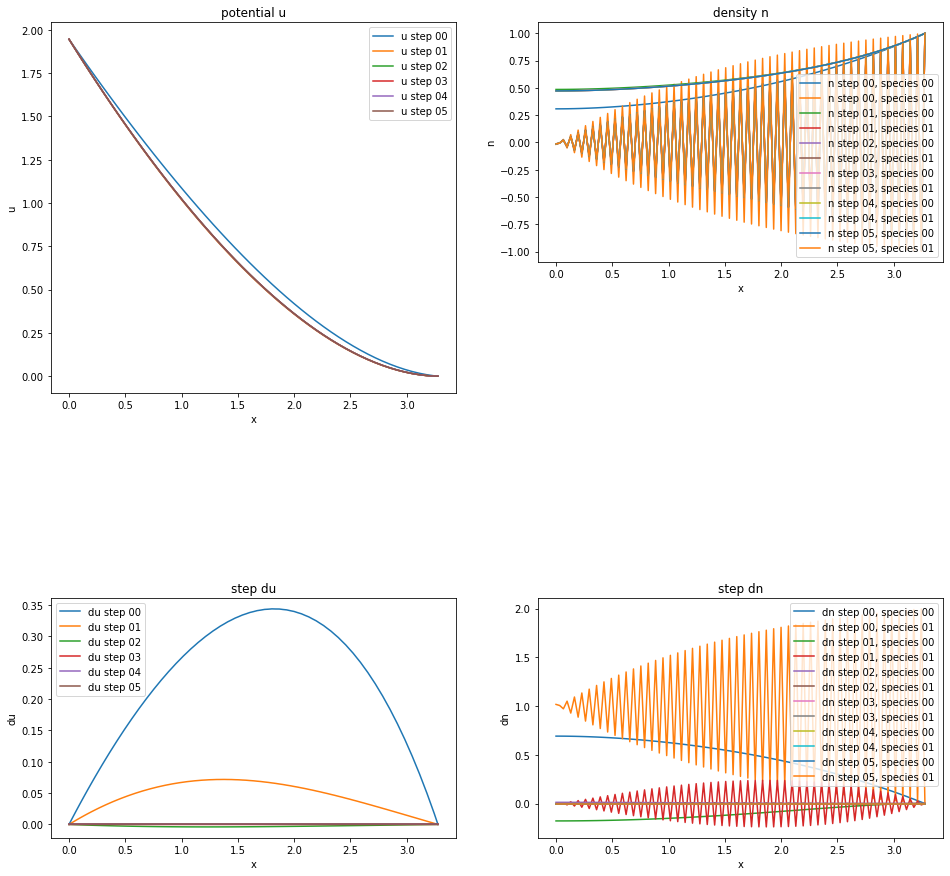

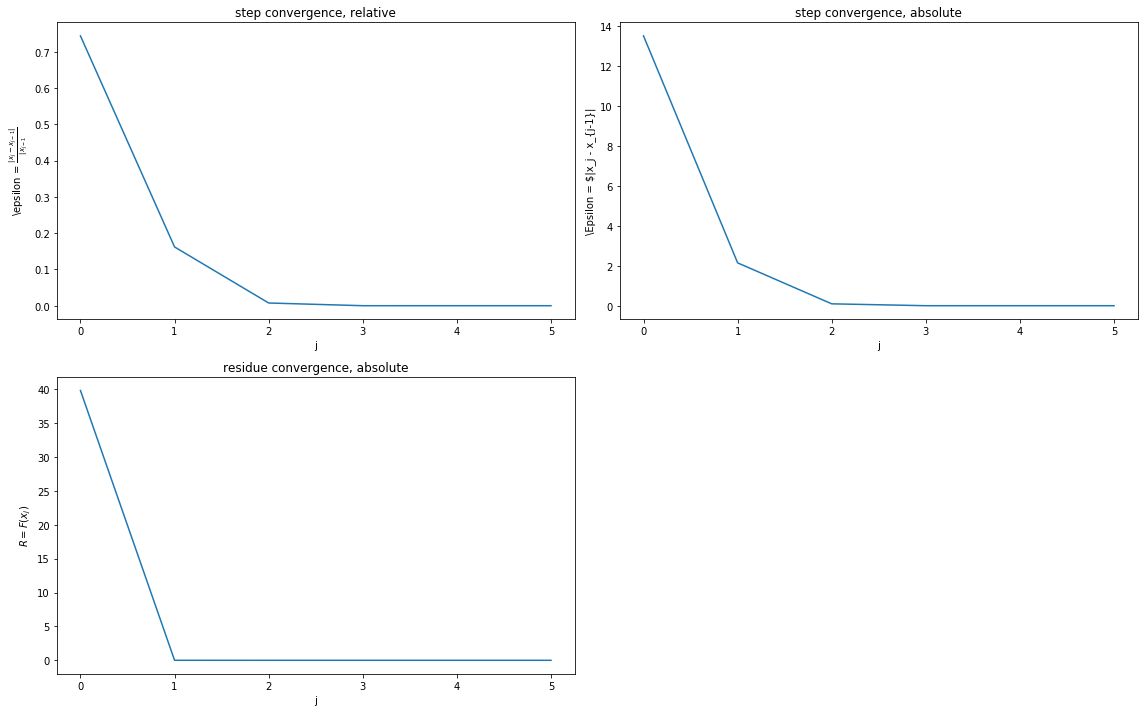

In [386]:
xij = pnp.solve()

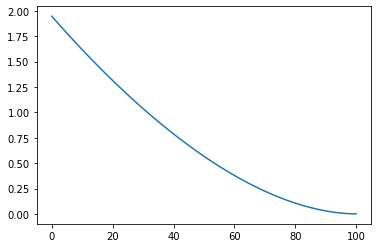

In [387]:
plt.plot(pnp.uij)

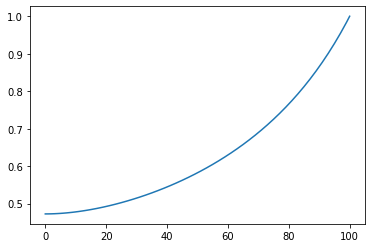

In [388]:
plt.plot(pnp.nij[0,:])

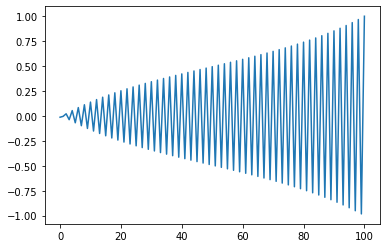

In [389]:
plt.plot(pnp.nij[1,:])

In [378]:
plt.plot(pnp.ni0[1,:])

AttributeError: 'PoissonNernstPlanckSystem' object has no attribute 'ni0'

In [252]:
pnp.leftPotentialBC([0])

19.460878998938806

In [258]:
pnp.rightConcentrationBC[0]([0,1,2])

1.0

In [153]:
xi0 = np.concatenate([pnp.ui0, pnp.ni0.flatten()])

In [157]:
nij1 = xi0[pnp.Ni:]

In [160]:
nijk1 = nij1.reshape( pnp.M, pnp.Ni )

In [162]:
zi0nijk1 = pnp.zi0*nijk1

In [166]:
zi0nijk1

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [165]:
zi0nijk1.shape

(2, 1001)

In [167]:
rhoij1 = zi0nijk1.sum(axis=0)

In [168]:
rhoij1

array([0., 0., 0., ..., 0., 0., 0.])

In [169]:
rhoij1.shape

(1001,)

In [170]:
Fn = np.zeros([pnp.M, pnp.Ni])

In [173]:
Fn.shape

(2, 1001)

In [216]:
xij

array([-1.94608790e+001, -1.94219572e+001, -1.93830355e+001, ...,
       -4.94065646e-324, -9.88131292e-323,  0.00000000e+000])

In [205]:
func = [(lambda n: pnp.leftNeumannBC(n,pnp.c_scaled[k])) for k in range(pnp.M)]

In [209]:
func[0](1)

TypeError: leftNeumannBC() takes 2 positional arguments but 3 were given

In [201]:
pnp.c_scaled[]

array([1., 1.])

In [202]:
pnp.M

2

In [181]:
uij = xij[:pnp.Ni] * pnp.u_unit

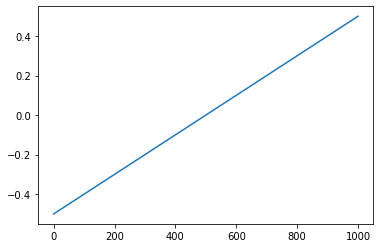

In [311]:
plt.plot(uij)

In [312]:
pnp.u0

-19.460878998938806

In [313]:
pnp.u1

19.460878998938806

In [185]:
nij=xij[pnp.Ni:]

In [189]:
nijk = nij.reshape((pnp.M,pnp.Ni))

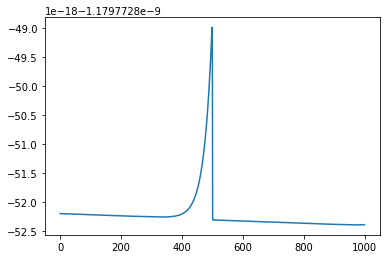

In [191]:
plt.plot(nijk[0,:])

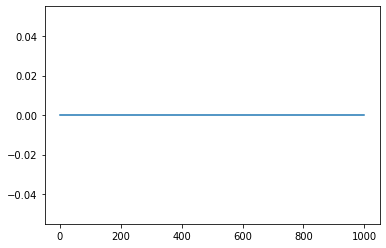

In [192]:
plt.plot(nijk[1,:])

In [83]:
pnp.c_scaled = np.array([2,3],dtype=float)

In [84]:
pnp.c_scaled

array([2., 3.])

In [134]:
np.kron?

In [136]:
np.kron(pnp.c_scaled,np.ones((pnp.Ni,1))).T

array([[2., 2., 2., ..., 2., 2., 2.],
       [3., 3., 3., ..., 3., 3., 3.]])

In [137]:
ni0 = np.kron( pnp.c_scaled, np.ones((pnp.Ni,1)) ).T

In [138]:
ni0

array([[2., 2., 2., ..., 2., 2., 2.],
       [3., 3., 3., ..., 3., 3., 3.]])

In [143]:
ni0.flatten().reshape(2,pnp.Ni)

array([[2., 2., 2., ..., 2., 2., 2.],
       [3., 3., 3., ..., 3., 3., 3.]])

In [116]:
np.kron(np.ones((pnp.Ni,1)),pnp.c_scaled)

array([[2., 3.],
       [2., 3.],
       [2., 3.],
       ...,
       [2., 3.],
       [2., 3.],
       [2., 3.]])

In [34]:
uij = xij[:pnp.Ni] * pnp.u_unit

In [35]:
nij = xij[pnp.Ni:] * pnp.c_unit

In [36]:
nij

array([-4.14339660e-09, -4.14339660e-09, -4.14339660e-09, ...,
        9.24633040e-02,  9.61573447e-02,  1.00000000e-01])

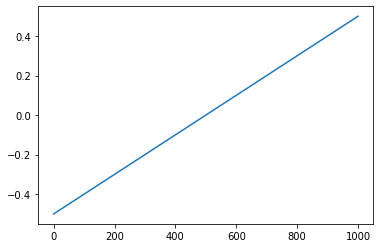

In [37]:
plt.plot(uij)

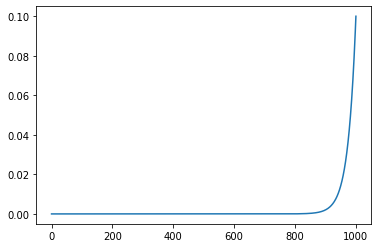

In [38]:
plt.plot(nij)

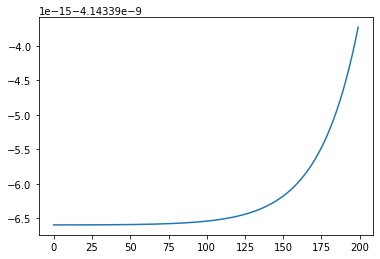

In [42]:
plt.plot(nij[:200])

/home/jotelha/venv/jlh-imtek-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """Entry point for launching an IPython kernel.


(1e-09, 1)

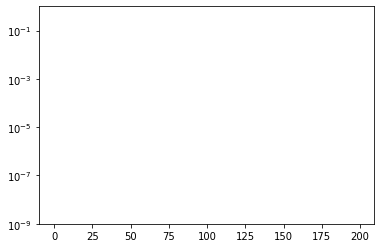

In [54]:
plt.semilogy(nij[:200])
plt.ylim(1e-9,1)

In [52]:
nij[0]

-4.1433965985243116e-09